# About this notebook  

TBD...

# Data Loading

In [1]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
os.listdir("../input/cassava-leaf-disease-classification")

['train_tfrecords',
 'train_images',
 'test_images',
 'label_num_to_disease_map.json',
 'sample_submission.csv',
 'train.csv',
 'test_tfrecords']

In [3]:
# train = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
# train = pd.read_csv("../input/cassava-leaf-disease-merged/oversample-0124.csv")  # label 0124 x3

train_id = pd.read_csv("../input/cassava-leaf-disease-merged/merged.csv")["image_id"]
dist = pd.read_csv("distillation_label/ensemble-v3.csv", header=None)
train_label = pd.DataFrame(dist.idxmax(axis=1), columns=["label"])
train = pd.concat([train_id, train_label, dist], axis=1)

test = pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv")
label_map = pd.read_json("../input/cassava-leaf-disease-classification/label_num_to_disease_map.json", orient="index")

display(train.head())
display(test.head())
display(label_map)

,image_id,label,0,1,2,3,4
0,1000015157.jpg,0,0.373521,0.296580,0.124931,0.018632,0.186336
1,1000201771.jpg,3,0.020839,0.027160,0.037688,0.886378,0.027935
2,100042118.jpg,4,0.028102,0.335759,0.043405,0.054358,0.538376
3,1000723321.jpg,1,0.021610,0.843521,0.029899,0.046169,0.058801
4,1000812911.jpg,3,0.023698,0.019814,0.022040,0.913077,0.021371


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='label'>

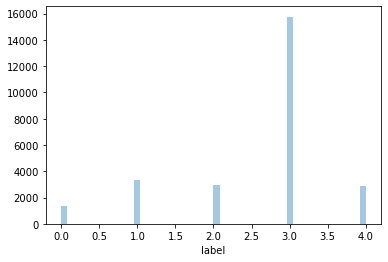

In [4]:
sns.distplot(train["label"], kde=False)

# Directory settings

In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = "./"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# TRAIN_PATH = "../input/cassava-leaf-disease-classification/train_images"
TRAIN_PATH = "../input/cassava-leaf-disease-merged/train"
TEST_PATH = "../input/cassava-leaf-disease-classification/test_images"

# CFG

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug = False
    apex = True
    print_freq = 100
    num_workers = 4
    model_name = "tf_efficientnet_b4_ns"  # resnext50_32x4d, seresnext50_32x4d, tf_efficientnet_b3_ns, vit_base_patch16_384, deit_base_patch16_384
    batch_size = 16
    gradient_accumulation_steps = 2
    size = 384 if "it_base_" in model_name else 512
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    criterion = "BiTemperedLoss"  # ['CrossEntropyLoss', 'BiTemperedLoss']
    btl_t1 = 0.3  # Bi-Tempered Logistic Loss
    btl_t2 = 1.0
    label_smoothing = 0.2
    kd_temperature = 10  # DistillationLoss
    kd_alpha = 0.3  # DistillationLoss
    scheduler = "CosineAnnealingWarmRestarts"  # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts', 'CosineAnnealingWarmupRestarts']
    scheduler_batch_update = True
    epochs = 10
    # factor = 0.2  # ReduceLROnPlateau
    # patience = 4  # ReduceLROnPlateau
    # eps = 1e-6  # ReduceLROnPlateau
    # T_max = 10  # CosineAnnealingLR
    T_0 = (
        len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs + 5
    )  # CosineAnnealingWarmRestarts
    # first_cycle_steps = (
    #     len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs + 5
    # )  # CosineAnnealingWarmupRestarts for batch update
    # warmup_steps = first_cycle_steps // 10  # CosineAnnealingWarmupRestarts
    # gamma = 0.8  # CosineAnnealingWarmupRestarts
    lr = 1e-4
    min_lr = 2e-6
    weight_decay = 1e-6
    max_grad_norm = 1000
    seed = 4678
    target_size = 5
    target_col = "label"
    train = True
    inference = False


if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [7]:
# ====================================================
# Library
# ====================================================
import sys

sys.path.append("../input/pytorch-image-models/pytorch-image-models-master")
sys.path.append("../input/pytorchcosineannealingwithwarmup")
sys.path.append("../input/bitemperedlogloss/")
sys.path.append("../input/image-fmix/FMix-master")

import math
import os
import random
import shutil
import time
import warnings
from collections import Counter, defaultdict
from contextlib import contextmanager
from functools import partial
from pathlib import Path

import bi_tempered_loss_pytorch as btl
import cv2
import numpy as np
import pandas as pd
import scipy as sp
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from albumentations import (
    CenterCrop,
    CoarseDropout,
    Compose,
    Cutout,
    HorizontalFlip,
    HueSaturationValue,
    IAAAdditiveGaussianNoise,
    ImageOnlyTransform,
    Normalize,
    OneOf,
    RandomBrightness,
    RandomBrightnessContrast,
    RandomContrast,
    RandomCrop,
    RandomResizedCrop,
    Resize,
    Rotate,
    ShiftScaleRotate,
    Transpose,
    VerticalFlip,
)
from albumentations.pytorch import ToTensorV2
from cosine_annearing_with_warmup import CosineAnnealingWarmupRestarts
from fmix import sample_mask
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from torch.nn.parameter import Parameter
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

if CFG.apex:
    from apex import amp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utils

In [8]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=CFG.seed)

# CV split

In [9]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, "fold"] = int(n)
folds["fold"] = folds["fold"].astype(int)
print(folds.groupby(["fold", CFG.target_col]).size())

fold  label
0     0         279
      1         671
      2         590
      3        3153
      4         575
1     0         278
      1         671
      2         590
      3        3154
      4         575
2     0         278
      1         672
      2         589
      3        3153
      4         575
3     0         278
      1         672
      2         589
      3        3153
      4         575
4     0         278
      1         672
      2         589
      3        3153
      4         575
dtype: int64


# Dataset

In [10]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.hard_target = df["label"].values
        self.soft_target = df[[0, 1, 2, 3, 4]].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TRAIN_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        hard_target = torch.tensor(self.hard_target[idx]).long()
        soft_target = torch.tensor(self.soft_target[idx]).float()
        return image, hard_target, soft_target


class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TEST_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image

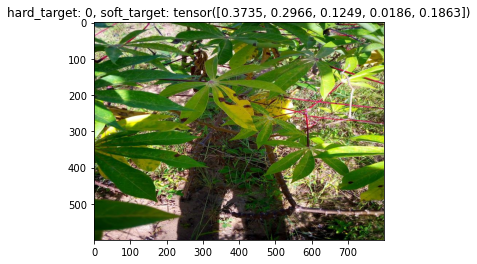

In [11]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, hard_target, soft_target = train_dataset[i]
    plt.imshow(image)
    plt.title(f"hard_target: {hard_target}, soft_target: {soft_target}")
    plt.show()

# Transforms

In [12]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):

    if data == "train":
        return Compose(
            [
                # Resize(CFG.size, CFG.size),
                RandomResizedCrop(CFG.size, CFG.size),
                Transpose(p=0.5),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                CoarseDropout(p=0.5),
                Cutout(p=0.5),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return Compose(
            [
                Resize(CFG.size, CFG.size),
                CenterCrop(CFG.size, CFG.size),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

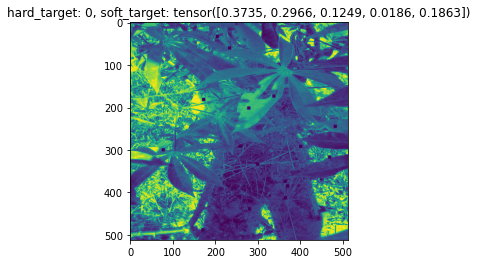

In [13]:
train_dataset = TrainDataset(train, transform=get_transforms(data="train"))

for i in range(1):
    image, hard_target, soft_target = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f"hard_target: {hard_target}, soft_target: {soft_target}")
    plt.show()

# CutMix / FMix


In [14]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


def cutmix(data, target, soft_target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]
    shuffled_soft_target = soft_target[indices]

    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, soft_target, shuffled_target, shuffled_soft_target, lam)

    return new_data, targets


def fmix(data, targets, soft_target, alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft, reformulate)
    if CFG.apex:
        # mask = torch.tensor(mask, device=device).float()
        mask = mask.astype(np.float32)
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    shuffled_soft_target = soft_target[indices]
    x1 = torch.from_numpy(mask).to(device) * data
    x2 = torch.from_numpy(1 - mask).to(device) * shuffled_data
    targets = (targets, soft_target, shuffled_targets, shuffled_soft_target, lam)

    return (x1 + x2), targets

# MixUp

In [15]:
# https://github.com/yuhao318/mwh/blob/e9e2da8fc6/utils.py
def mixup(x, y, soft_target, alpha=1.0, use_cuda=True):

    """Compute the mixup data. Return mixed inputs, pairs of targets, and lambda"""
    if alpha > 0.0:
        lam = np.random.beta(alpha, alpha)
        lam = max(lam, 1 - lam)
        # lam = min(lam, 1-lam)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    ## SYM
    # mixed_x = lam * x + (1 - lam) * x[index,:]
    # mixed_y = (1 - lam) * x + lam * x[index,:]
    # mixed_image  = torch.cat([mixed_x,mixed_y], 0)
    # y_a, y_b = y, y[index]
    # mixed_label  = torch.cat([y_a,y_b], 0)

    ## Reduce batch size
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j

    ## NO SYM
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    shuffled_soft_target = soft_target[index]

    ## Only Alpha
    # mixed_x = 0.5 * x + (1 - 0.5) * x[index,:]
    # mixed_image  = mixed_x
    # y_a, y_b = y, y[index]
    # ind_label = torch.randint_like(y, 0,2)
    # mixed_label  = ind_label * y_a + (1-ind_label) * y_b

    ## Reduce batch size and SYM
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j
    # mixed_y = (1 - lam) * x_i + lam * x_j
    # mixed_x  = torch.cat([mixed_x,mixed_y], 0)
    # y_b = torch.cat([y_b,y_a], 0)
    # y_a = y

    # return mixed_image, mixed_label, lam
    return mixed_x, (y_a, soft_target, y_b, shuffled_soft_target, lam)

# MODEL

In [16]:
# ====================================================
# MODEL
# ====================================================
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_name="resnext50_32x4d", pretrained=False):
        super().__init__()
        self.model_name = model_name

        if model_name.startswith("deit_"):
            self.model = torch.hub.load("facebookresearch/deit:main", model_name, pretrained=True)

            if model_name == "deit_base_patch16_384":
                n_features = self.model.head.in_features
                self.model.head = nn.Linear(n_features, CFG.target_size)

        else:
            self.model = timm.create_model(model_name, pretrained=pretrained)

            if "resnext50_32x4d" in model_name:
                n_features = self.model.fc.in_features
                self.model.fc = nn.Linear(n_features, CFG.target_size)

            elif model_name.startswith("tf_efficientnet"):
                n_features = self.model.classifier.in_features
                self.model.classifier = nn.Linear(n_features, CFG.target_size)

            elif model_name.startswith("vit_"):
                n_features = self.model.head.in_features
                self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [17]:
def freeze_batch_normalization(model):
    if CFG.model_name.startswith("tf_efficientnet_"):
        for name1, child1 in model.named_children():
            for name2, child2 in child1.named_children():
                # print(f"===== {name2} =====")
                if name2.startswith("bn"):
                    for param in child2.parameters():
                        param.requires_grad = False
                        # print(param.requires_grad)

                for child3 in child2.children():
                    if isinstance(child3, nn.modules.container.Sequential):
                        for child4 in child3.children():
                            for child5 in child4.children():
                                if isinstance(child5, nn.BatchNorm2d):
                                    # print(child5)
                                    for param in child5.parameters():
                                        param.requires_grad = False
                                        # print(param.requires_grad)

    if CFG.model_name.startswith("vit_"):
        try:
            for m in model.modules():
                if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                    m.eval()
        except ValuError:
            print("error with batchnorm2d or layernorm")
            return

In [18]:
model = CassvaImgClassifier(model_name=CFG.model_name, pretrained=False)
freeze_batch_normalization(model)
# print(model)

train_dataset = TrainDataset(train, transform=get_transforms(data="train"))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

for image, hard_target, soft_target in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.0462,  0.0081, -0.0124,  0.0075,  0.0099],
        [ 0.1687,  0.0044,  0.0521,  0.0483,  0.0483],
        [ 0.6108, -0.3040,  0.2413,  0.0911,  0.2267],
        [ 0.0497,  0.0122, -0.0052,  0.0025,  0.0111]],
       grad_fn=<AddmmBackward>)


# Loss functions

In [19]:
class BiTemperedLogisticLoss(nn.Module):
    def __init__(self, t1, t2, smoothing=0.0):
        super(BiTemperedLogisticLoss, self).__init__()
        self.t1 = t1
        self.t2 = t2
        self.smoothing = smoothing

    def forward(self, logit_label, truth_label):
        loss_label = btl.bi_tempered_logistic_loss(
            logit_label, truth_label, t1=self.t1, t2=self.t2, label_smoothing=self.smoothing, reduction="none"
        )

        loss_label = loss_label.mean()
        return loss_label

In [20]:
class DistillationLoss(nn.Module):
    def __init__(self, criterion):
        super().__init__()
        self.criterion = criterion
        self.alpha = CFG.kd_alpha
        self.T = CFG.kd_temperature

    # https://github.com/peterliht/knowledge-distillation-pytorch/blob/b1e4b6acb8d4e138ad12ba1aac22d5da42a85c10/model/net.py#L100
    def forward(self, outputs, hard_target, soft_target):
        """
        Compute the knowledge-distillation (KD) loss given outputs, labels.
        "Hyperparameters": temperature and alpha
        NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
        and student expects the input tensor to be log probabilities! See Issue #2
        """
        KD_loss = nn.KLDivLoss()(F.log_softmax(outputs / self.T, dim=1), F.softmax(soft_target / self.T, dim=1)) * (
            self.alpha * self.T * self.T
        ) + self.criterion(outputs, hard_target) * (1.0 - self.alpha)

        return KD_loss

# Helper functions

In [21]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device, scheduler_batch_update=True):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, hard_target, soft_target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        hard_target = hard_target.to(device)
        soft_target = soft_target.to(device)
        batch_size = hard_target.shape[0]

        # CutMix, FMix
        if epoch <= 1 or epoch >= CFG.epochs - 1:
            mix_decision = 0.75  # Disable CutMix, FMix for final epoch
        else:
            mix_decision = np.random.rand()

        if epoch >= CFG.epochs - 4:
            mix_decision *= 2  # Reduce probability

        if mix_decision < 0.25:
            images, labels = cutmix(images, hard_target, soft_target, 1.0)
        elif mix_decision >= 0.25 and mix_decision < 0.5:
            images, labels = fmix(
                images, hard_target, soft_target, alpha=1.0, decay_power=5.0, shape=(CFG.size, CFG.size)
            )
        elif mix_decision >= 0.5 and mix_decision < 0.75:
            images, labels = mixup(images, hard_target, soft_target, alpha=0.5)

        y_preds = model(images.float())

        if mix_decision < 0.75:
            loss = criterion(y_preds, labels[0], labels[1]) * labels[4] + criterion(y_preds, labels[2], labels[3]) * (
                1.0 - labels[4]
            )
        else:
            loss = criterion(y_preds, hard_target, soft_target)

        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

            if CFG.scheduler_batch_update:
                scheduler.step()

            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                "Epoch: [{0}][{1}/{2}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) "
                "Grad: {grad_norm:.4f} "
                "LR: {lr:.6f}  ".format(
                    epoch + 1,
                    step,
                    len(train_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(train_loader)),
                    grad_norm=grad_norm,
                    lr=scheduler.get_lr()[0],
                )
            )
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, hard_target, soft_target) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        hard_target = hard_target.to(device)
        soft_target = soft_target.to(device)
        batch_size = hard_target.shape[0]
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, hard_target, soft_target)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to("cpu").numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                "EVAL: [{0}/{1}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) ".format(
                    step,
                    len(valid_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(valid_loader)),
                )
            )
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state["model"])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to("cpu").numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [22]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds["fold"] != fold].index
    val_idx = folds[folds["fold"] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data="train"))
    train_dataset_no_aug = TrainDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_no_aug = DataLoader(
        train_dataset_no_aug,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer, mode="min", factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps
            )
        elif CFG.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer,
                first_cycle_steps=CFG.first_cycle_steps,
                cycle_mult=1.0,
                max_lr=CFG.lr,
                min_lr=CFG.min_lr,
                warmup_steps=CFG.warmup_steps,
                gamma=CFG.gamma,
            )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CassvaImgClassifier(CFG.model_name, pretrained=True)
    freeze_batch_normalization(model)

    model.to(device)

    # Use multi GPU
    if device == torch.device("cuda") and not CFG.apex:
        model = torch.nn.DataParallel(model)  # make parallel
        # torch.backends.cudnn.benchmark=True

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if CFG.criterion == "CrossEntropyLoss":
            hard_criterion = nn.CrossEntropyLoss()
        elif CFG.criterion == "BiTemperedLoss":
            hard_criterion = BiTemperedLogisticLoss(t1=CFG.btl_t1, t2=CFG.btl_t2, smoothing=CFG.label_smoothing)

        criterion = DistillationLoss(hard_criterion)
        return criterion

    criterion = get_criterion()

    # ====================================================
    # loop
    # ====================================================
    best_score = 0.0
    best_loss = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        if epoch <= 1 or epoch >= CFG.epochs - 1:
            avg_loss = train_fn(
                train_loader_no_aug, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )
        else:
            avg_loss = train_fn(
                train_loader, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values

        if not CFG.scheduler_batch_update:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            elif isinstance(scheduler, CosineAnnealingLR):
                scheduler.step()
            elif isinstance(scheduler, CosineAnnealingWarmRestarts):
                scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Accuracy: {score}")

        if score > best_score:
            best_score = score
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth"
            )

        if epoch == CFG.epochs - 1:
            LOGGER.info(f"Epoch {epoch+1} - Save final model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_final.pth"
            )

    check_point = torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth")
    valid_folds[[str(c) for c in range(5)]] = check_point["preds"]
    valid_folds["preds"] = check_point["preds"].argmax(1)

    return valid_folds

In [23]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df["preds"].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f"Score: {score:<.5f}")

    if CFG.train:
        # train
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)

    if CFG.inference:
        # inference
        model = CassvaImgClassifier(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth") for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data="valid"))
        test_loader = DataLoader(
            test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True
        )
        predictions = inference(model, states, test_loader, device)
        # submission
        test["label"] = predictions.argmax(1)
        test[["image_id", "label"]].to_csv(OUTPUT_DIR + "submission.csv", index=False)

In [24]:
if __name__ == "__main__":
    main()

========== fold: 0 training ==========
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth


Epoch: [1][0/1316] Elapsed 0m 8s (remain 178m 56s) Loss: 0.2283(0.2283) Grad: 0.2275 LR: 0.000100  
Epoch: [1][100/1316] Elapsed 0m 39s (remain 7m 58s) Loss: 0.0699(0.1506) Grad: 0.1459 LR: 0.000100  
Epoch: [1][200/1316] Elapsed 1m 11s (remain 6m 36s) Loss: 0.1006(0.1260) Grad: 0.3104 LR: 0.000100  
Epoch: [1][300/1316] Elapsed 1m 42s (remain 5m 46s) Loss: 0.0731(0.1118) Grad: 0.2177 LR: 0.000100  
Epoch: [1][400/1316] Elapsed 2m 13s (remain 5m 5s) Loss: 0.0560(0.1018) Grad: 0.1839 LR: 0.000100  
Epoch: [1][500/1316] Elapsed 2m 45s (remain 4m 28s) Loss: 0.0497(0.0940) Grad: 0.2010 LR: 0.000100  
Epoch: [1][600/1316] Elapsed 3m 16s (remain 3m 53s) Loss: 0.0656(0.0893) Grad: 0.2556 LR: 0.000099  
Epoch: [1][700/1316] Elapsed 3m 48s (remain 3m 20s) Loss: 0.0588(0.0855) Grad: 0.1859 LR: 0.000099  
Epoch: [1][800/1316] Elapsed 4m 20s (remain 2m 47s) Loss: 0.0579(0.0824) Grad: 0.1650 LR: 0.000099  
Epoch: [1][900/1316] Elapsed 4m 52s (remain 2m 14s) Loss: 0.0437(0.0796) Grad: 0.1818 LR: 0.0

Epoch 1 - avg_train_loss: 0.0715  avg_val_loss: 0.0467  time: 483s
Epoch 1 - Accuracy: 0.9267274107820805
Epoch 1 - Save Best Score: 0.9267 Model


EVAL: [329/330] Elapsed 0m 59s (remain 0m 0s) Loss: 0.0397(0.0467) 
Epoch: [2][0/1316] Elapsed 0m 1s (remain 24m 55s) Loss: 0.0372(0.0372) Grad: 0.1713 LR: 0.000098  
Epoch: [2][100/1316] Elapsed 0m 31s (remain 6m 18s) Loss: 0.0372(0.0416) Grad: 0.1576 LR: 0.000097  
Epoch: [2][200/1316] Elapsed 1m 2s (remain 5m 47s) Loss: 0.0240(0.0388) Grad: 0.1099 LR: 0.000097  
Epoch: [2][300/1316] Elapsed 1m 33s (remain 5m 14s) Loss: 0.0584(0.0386) Grad: 0.1983 LR: 0.000096  
Epoch: [2][400/1316] Elapsed 2m 3s (remain 4m 42s) Loss: 0.0369(0.0380) Grad: 0.1647 LR: 0.000096  
Epoch: [2][500/1316] Elapsed 2m 34s (remain 4m 11s) Loss: 0.0292(0.0374) Grad: 0.1272 LR: 0.000095  
Epoch: [2][600/1316] Elapsed 3m 4s (remain 3m 39s) Loss: 0.0523(0.0378) Grad: 0.1791 LR: 0.000095  
Epoch: [2][700/1316] Elapsed 3m 34s (remain 3m 8s) Loss: 0.0381(0.0380) Grad: 0.2507 LR: 0.000094  
Epoch: [2][800/1316] Elapsed 4m 4s (remain 2m 37s) Loss: 0.0375(0.0375) Grad: 0.1774 LR: 0.000094  
Epoch: [2][900/1316] Elapsed 4

Epoch 2 - avg_train_loss: 0.0375  avg_val_loss: 0.0420  time: 436s
Epoch 2 - Accuracy: 0.9326119969627942
Epoch 2 - Save Best Score: 0.9326 Model


EVAL: [329/330] Elapsed 0m 35s (remain 0m 0s) Loss: 0.0173(0.0420) 
Epoch: [3][0/1316] Elapsed 0m 1s (remain 25m 57s) Loss: 0.1086(0.1086) Grad: 0.3595 LR: 0.000091  
Epoch: [3][100/1316] Elapsed 0m 33s (remain 6m 43s) Loss: 0.0895(0.0968) Grad: 0.2768 LR: 0.000090  
Epoch: [3][200/1316] Elapsed 1m 5s (remain 6m 4s) Loss: 0.0741(0.0993) Grad: 0.1672 LR: 0.000089  
Epoch: [3][300/1316] Elapsed 1m 37s (remain 5m 28s) Loss: 0.0535(0.0971) Grad: 0.2066 LR: 0.000088  
Epoch: [3][400/1316] Elapsed 2m 9s (remain 4m 54s) Loss: 0.0942(0.1000) Grad: 0.1589 LR: 0.000088  
Epoch: [3][500/1316] Elapsed 2m 40s (remain 4m 21s) Loss: 0.0872(0.0997) Grad: 0.1468 LR: 0.000087  
Epoch: [3][600/1316] Elapsed 3m 12s (remain 3m 49s) Loss: 0.0987(0.0995) Grad: 0.1060 LR: 0.000086  
Epoch: [3][700/1316] Elapsed 3m 45s (remain 3m 17s) Loss: 0.0813(0.0986) Grad: 0.1714 LR: 0.000085  
Epoch: [3][800/1316] Elapsed 4m 17s (remain 2m 45s) Loss: 0.1017(0.0974) Grad: 0.1180 LR: 0.000084  
Epoch: [3][900/1316] Elapsed

Epoch 3 - avg_train_loss: 0.0965  avg_val_loss: 0.0430  time: 461s
Epoch 3 - Accuracy: 0.9350797266514806
Epoch 3 - Save Best Score: 0.9351 Model


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0175(0.0430) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 28m 50s) Loss: 0.0392(0.0392) Grad: 0.1903 LR: 0.000080  
Epoch: [4][100/1316] Elapsed 0m 33s (remain 6m 42s) Loss: 0.0602(0.0819) Grad: 0.1781 LR: 0.000079  
Epoch: [4][200/1316] Elapsed 1m 5s (remain 6m 3s) Loss: 0.0968(0.0890) Grad: 0.1893 LR: 0.000078  
Epoch: [4][300/1316] Elapsed 1m 37s (remain 5m 30s) Loss: 0.0361(0.0889) Grad: 0.1898 LR: 0.000077  
Epoch: [4][400/1316] Elapsed 2m 10s (remain 4m 57s) Loss: 0.1385(0.0891) Grad: 0.1558 LR: 0.000076  
Epoch: [4][500/1316] Elapsed 2m 43s (remain 4m 25s) Loss: 0.1331(0.0901) Grad: 0.1706 LR: 0.000075  
Epoch: [4][600/1316] Elapsed 3m 15s (remain 3m 52s) Loss: 0.1577(0.0898) Grad: 0.1443 LR: 0.000074  
Epoch: [4][700/1316] Elapsed 3m 47s (remain 3m 19s) Loss: 0.0633(0.0909) Grad: 0.2075 LR: 0.000073  
Epoch: [4][800/1316] Elapsed 4m 19s (remain 2m 46s) Loss: 0.0904(0.0914) Grad: 0.2333 LR: 0.000072  
Epoch: [4][900/1316] Elapse

Epoch 4 - avg_train_loss: 0.0906  avg_val_loss: 0.0451  time: 458s
Epoch 4 - Accuracy: 0.9329916476841306


EVAL: [329/330] Elapsed 0m 35s (remain 0m 0s) Loss: 0.0200(0.0451) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 28m 29s) Loss: 0.0582(0.0582) Grad: 0.1129 LR: 0.000066  
Epoch: [5][100/1316] Elapsed 0m 33s (remain 6m 40s) Loss: 0.0445(0.0893) Grad: 0.1930 LR: 0.000065  
Epoch: [5][200/1316] Elapsed 1m 5s (remain 6m 2s) Loss: 0.0460(0.0881) Grad: 0.1228 LR: 0.000064  
Epoch: [5][300/1316] Elapsed 1m 36s (remain 5m 26s) Loss: 0.0233(0.0878) Grad: 0.0840 LR: 0.000063  
Epoch: [5][400/1316] Elapsed 2m 8s (remain 4m 53s) Loss: 0.0443(0.0876) Grad: 0.1804 LR: 0.000062  
Epoch: [5][500/1316] Elapsed 2m 40s (remain 4m 20s) Loss: 0.0532(0.0870) Grad: 0.1506 LR: 0.000061  
Epoch: [5][600/1316] Elapsed 3m 12s (remain 3m 49s) Loss: 0.1174(0.0869) Grad: 0.0935 LR: 0.000059  
Epoch: [5][700/1316] Elapsed 3m 44s (remain 3m 17s) Loss: 0.0546(0.0873) Grad: 0.2100 LR: 0.000058  
Epoch: [5][800/1316] Elapsed 4m 16s (remain 2m 45s) Loss: 0.0537(0.0880) Grad: 0.1651 LR: 0.000057  
Epoch: [5][900/1316] Elapsed

Epoch 5 - avg_train_loss: 0.0886  avg_val_loss: 0.0437  time: 458s
Epoch 5 - Accuracy: 0.9367881548974943
Epoch 5 - Save Best Score: 0.9368 Model


EVAL: [329/330] Elapsed 0m 35s (remain 0m 0s) Loss: 0.0174(0.0437) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 25m 16s) Loss: 0.1198(0.1198) Grad: 0.1325 LR: 0.000051  
Epoch: [6][100/1316] Elapsed 0m 33s (remain 6m 37s) Loss: 0.0724(0.0883) Grad: 0.2233 LR: 0.000050  
Epoch: [6][200/1316] Elapsed 1m 5s (remain 6m 1s) Loss: 0.0402(0.0877) Grad: 0.1274 LR: 0.000049  
Epoch: [6][300/1316] Elapsed 1m 36s (remain 5m 25s) Loss: 0.0748(0.0859) Grad: 0.2369 LR: 0.000048  
Epoch: [6][400/1316] Elapsed 2m 8s (remain 4m 52s) Loss: 0.0283(0.0868) Grad: 0.1186 LR: 0.000046  
Epoch: [6][500/1316] Elapsed 2m 39s (remain 4m 20s) Loss: 0.0807(0.0855) Grad: 0.0704 LR: 0.000045  
Epoch: [6][600/1316] Elapsed 3m 11s (remain 3m 47s) Loss: 0.0475(0.0856) Grad: 0.1305 LR: 0.000044  
Epoch: [6][700/1316] Elapsed 3m 43s (remain 3m 16s) Loss: 0.0429(0.0857) Grad: 0.2034 LR: 0.000043  
Epoch: [6][800/1316] Elapsed 4m 14s (remain 2m 43s) Loss: 0.1417(0.0857) Grad: 0.1995 LR: 0.000042  
Epoch: [6][900/1316] Elapsed

Epoch 6 - avg_train_loss: 0.0862  avg_val_loss: 0.0416  time: 455s
Epoch 6 - Accuracy: 0.9379271070615034
Epoch 6 - Save Best Score: 0.9379 Model


EVAL: [329/330] Elapsed 0m 35s (remain 0m 0s) Loss: 0.0173(0.0416) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 27m 45s) Loss: 0.1567(0.1567) Grad: 0.1461 LR: 0.000036  
Epoch: [7][100/1316] Elapsed 0m 33s (remain 6m 38s) Loss: 0.0685(0.0670) Grad: 0.0645 LR: 0.000035  
Epoch: [7][200/1316] Elapsed 1m 4s (remain 5m 56s) Loss: 0.1684(0.0640) Grad: 0.1246 LR: 0.000034  
Epoch: [7][300/1316] Elapsed 1m 35s (remain 5m 22s) Loss: 0.1032(0.0652) Grad: 0.0992 LR: 0.000033  
Epoch: [7][400/1316] Elapsed 2m 6s (remain 4m 49s) Loss: 0.0302(0.0644) Grad: 0.1662 LR: 0.000032  
Epoch: [7][500/1316] Elapsed 2m 38s (remain 4m 17s) Loss: 0.1005(0.0651) Grad: 0.0766 LR: 0.000030  
Epoch: [7][600/1316] Elapsed 3m 9s (remain 3m 45s) Loss: 0.0502(0.0653) Grad: 0.1765 LR: 0.000029  
Epoch: [7][700/1316] Elapsed 3m 40s (remain 3m 13s) Loss: 0.1406(0.0660) Grad: 0.1862 LR: 0.000028  
Epoch: [7][800/1316] Elapsed 4m 11s (remain 2m 41s) Loss: 0.0628(0.0661) Grad: 0.2067 LR: 0.000027  
Epoch: [7][900/1316] Elapsed

Epoch 7 - avg_train_loss: 0.0649  avg_val_loss: 0.0392  time: 447s
Epoch 7 - Accuracy: 0.9411541381928625
Epoch 7 - Save Best Score: 0.9412 Model


EVAL: [329/330] Elapsed 0m 35s (remain 0m 0s) Loss: 0.0163(0.0392) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 26m 37s) Loss: 0.1437(0.1437) Grad: 0.1490 LR: 0.000022  
Epoch: [8][100/1316] Elapsed 0m 32s (remain 6m 27s) Loss: 0.0242(0.0678) Grad: 0.0877 LR: 0.000021  
Epoch: [8][200/1316] Elapsed 1m 3s (remain 5m 52s) Loss: 0.0948(0.0654) Grad: 0.0995 LR: 0.000020  
Epoch: [8][300/1316] Elapsed 1m 34s (remain 5m 18s) Loss: 0.0996(0.0641) Grad: 0.1071 LR: 0.000020  
Epoch: [8][400/1316] Elapsed 2m 5s (remain 4m 46s) Loss: 0.0258(0.0635) Grad: 0.0925 LR: 0.000019  
Epoch: [8][500/1316] Elapsed 2m 36s (remain 4m 14s) Loss: 0.0779(0.0632) Grad: 0.2958 LR: 0.000018  
Epoch: [8][600/1316] Elapsed 3m 7s (remain 3m 43s) Loss: 0.0304(0.0630) Grad: 0.1449 LR: 0.000017  
Epoch: [8][700/1316] Elapsed 3m 38s (remain 3m 11s) Loss: 0.0615(0.0627) Grad: 0.2848 LR: 0.000016  
Epoch: [8][800/1316] Elapsed 4m 9s (remain 2m 40s) Loss: 0.0351(0.0622) Grad: 0.2157 LR: 0.000015  
Epoch: [8][900/1316] Elapsed 

Epoch 8 - avg_train_loss: 0.0625  avg_val_loss: 0.0386  time: 446s
Epoch 8 - Accuracy: 0.9455201214882308
Epoch 8 - Save Best Score: 0.9455 Model


EVAL: [329/330] Elapsed 0m 35s (remain 0m 0s) Loss: 0.0168(0.0386) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 27m 31s) Loss: 0.0286(0.0286) Grad: 0.0744 LR: 0.000011  
Epoch: [9][100/1316] Elapsed 0m 33s (remain 6m 39s) Loss: 0.1401(0.0683) Grad: 0.1043 LR: 0.000011  
Epoch: [9][200/1316] Elapsed 1m 5s (remain 6m 0s) Loss: 0.1385(0.0663) Grad: 0.1233 LR: 0.000010  
Epoch: [9][300/1316] Elapsed 1m 36s (remain 5m 23s) Loss: 0.0245(0.0630) Grad: 0.0962 LR: 0.000009  
Epoch: [9][400/1316] Elapsed 2m 7s (remain 4m 51s) Loss: 0.0597(0.0597) Grad: 0.1987 LR: 0.000009  
Epoch: [9][500/1316] Elapsed 2m 39s (remain 4m 19s) Loss: 0.0751(0.0607) Grad: 0.2300 LR: 0.000008  
Epoch: [9][600/1316] Elapsed 3m 10s (remain 3m 47s) Loss: 0.0423(0.0603) Grad: 0.1377 LR: 0.000008  
Epoch: [9][700/1316] Elapsed 3m 42s (remain 3m 15s) Loss: 0.1013(0.0606) Grad: 0.3119 LR: 0.000007  
Epoch: [9][800/1316] Elapsed 4m 14s (remain 2m 43s) Loss: 0.0266(0.0605) Grad: 0.1822 LR: 0.000007  
Epoch: [9][900/1316] Elapsed

Epoch 9 - avg_train_loss: 0.0613  avg_val_loss: 0.0381  time: 452s
Epoch 9 - Accuracy: 0.9462794229309036
Epoch 9 - Save Best Score: 0.9463 Model


EVAL: [329/330] Elapsed 0m 35s (remain 0m 0s) Loss: 0.0162(0.0381) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 22m 50s) Loss: 0.0253(0.0253) Grad: 0.1592 LR: 0.000004  
Epoch: [10][100/1316] Elapsed 0m 31s (remain 6m 15s) Loss: 0.0252(0.0296) Grad: 0.1514 LR: 0.000004  
Epoch: [10][200/1316] Elapsed 1m 1s (remain 5m 39s) Loss: 0.0174(0.0290) Grad: 0.0192 LR: 0.000004  
Epoch: [10][300/1316] Elapsed 1m 31s (remain 5m 8s) Loss: 0.0331(0.0281) Grad: 0.2039 LR: 0.000003  
Epoch: [10][400/1316] Elapsed 2m 2s (remain 4m 38s) Loss: 0.0397(0.0278) Grad: 0.2134 LR: 0.000003  
Epoch: [10][500/1316] Elapsed 2m 33s (remain 4m 9s) Loss: 0.0303(0.0277) Grad: 0.1658 LR: 0.000003  
Epoch: [10][600/1316] Elapsed 3m 3s (remain 3m 38s) Loss: 0.0329(0.0272) Grad: 0.1813 LR: 0.000003  
Epoch: [10][700/1316] Elapsed 3m 34s (remain 3m 7s) Loss: 0.0181(0.0272) Grad: 0.0176 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 4m 3s (remain 2m 36s) Loss: 0.0297(0.0269) Grad: 0.1729 LR: 0.000002  
Epoch: [10][900/1316] E

Epoch 10 - avg_train_loss: 0.0269  avg_val_loss: 0.0390  time: 436s
Epoch 10 - Accuracy: 0.939445709946849
Epoch 10 - Save final model


EVAL: [329/330] Elapsed 0m 36s (remain 0m 0s) Loss: 0.0159(0.0390) 


========== fold: 0 result ==========
Score: 0.94628
========== fold: 1 training ==========


Epoch: [1][0/1316] Elapsed 0m 1s (remain 24m 38s) Loss: 0.2373(0.2373) Grad: 0.1992 LR: 0.000100  
Epoch: [1][100/1316] Elapsed 0m 33s (remain 6m 37s) Loss: 0.1036(0.1546) Grad: 0.1755 LR: 0.000100  
Epoch: [1][200/1316] Elapsed 1m 5s (remain 6m 1s) Loss: 0.1123(0.1282) Grad: 0.2278 LR: 0.000100  
Epoch: [1][300/1316] Elapsed 1m 36s (remain 5m 27s) Loss: 0.0901(0.1141) Grad: 0.2547 LR: 0.000100  
Epoch: [1][400/1316] Elapsed 2m 8s (remain 4m 52s) Loss: 0.0939(0.1046) Grad: 0.2356 LR: 0.000100  
Epoch: [1][500/1316] Elapsed 2m 39s (remain 4m 19s) Loss: 0.0580(0.0978) Grad: 0.1811 LR: 0.000100  
Epoch: [1][600/1316] Elapsed 3m 10s (remain 3m 46s) Loss: 0.0502(0.0923) Grad: 0.2178 LR: 0.000099  
Epoch: [1][700/1316] Elapsed 3m 41s (remain 3m 14s) Loss: 0.0713(0.0879) Grad: 0.2300 LR: 0.000099  
Epoch: [1][800/1316] Elapsed 4m 13s (remain 2m 42s) Loss: 0.0706(0.0842) Grad: 0.2847 LR: 0.000099  
Epoch: [1][900/1316] Elapsed 4m 44s (remain 2m 11s) Loss: 0.1117(0.0814) Grad: 0.2621 LR: 0.0000

Epoch 1 - avg_train_loss: 0.0730  avg_val_loss: 0.0428  time: 451s
Epoch 1 - Accuracy: 0.9362186788154897
Epoch 1 - Save Best Score: 0.9362 Model


EVAL: [329/330] Elapsed 0m 36s (remain 0m 0s) Loss: 0.0403(0.0428) 
Epoch: [2][0/1316] Elapsed 0m 1s (remain 26m 51s) Loss: 0.0453(0.0453) Grad: 0.1354 LR: 0.000098  
Epoch: [2][100/1316] Elapsed 0m 32s (remain 6m 34s) Loss: 0.0228(0.0397) Grad: 0.0761 LR: 0.000097  
Epoch: [2][200/1316] Elapsed 1m 4s (remain 5m 59s) Loss: 0.0437(0.0392) Grad: 0.1707 LR: 0.000097  
Epoch: [2][300/1316] Elapsed 1m 36s (remain 5m 23s) Loss: 0.0423(0.0396) Grad: 0.2468 LR: 0.000096  
Epoch: [2][400/1316] Elapsed 2m 7s (remain 4m 50s) Loss: 0.0428(0.0395) Grad: 0.1854 LR: 0.000096  
Epoch: [2][500/1316] Elapsed 2m 38s (remain 4m 18s) Loss: 0.0464(0.0393) Grad: 0.1978 LR: 0.000095  
Epoch: [2][600/1316] Elapsed 3m 9s (remain 3m 45s) Loss: 0.0490(0.0396) Grad: 0.2321 LR: 0.000095  
Epoch: [2][700/1316] Elapsed 3m 40s (remain 3m 13s) Loss: 0.0482(0.0393) Grad: 0.2203 LR: 0.000094  
Epoch: [2][800/1316] Elapsed 4m 12s (remain 2m 42s) Loss: 0.0289(0.0391) Grad: 0.1644 LR: 0.000094  
Epoch: [2][900/1316] Elapsed

Epoch 2 - avg_train_loss: 0.0392  avg_val_loss: 0.0417  time: 452s
Epoch 2 - Accuracy: 0.9348899012908124


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0778(0.0417) 
Epoch: [3][0/1316] Elapsed 0m 1s (remain 27m 50s) Loss: 0.0398(0.0398) Grad: 0.1744 LR: 0.000091  
Epoch: [3][100/1316] Elapsed 0m 34s (remain 6m 59s) Loss: 0.1141(0.0990) Grad: 0.2396 LR: 0.000090  
Epoch: [3][200/1316] Elapsed 1m 7s (remain 6m 17s) Loss: 0.0459(0.0990) Grad: 0.1414 LR: 0.000089  
Epoch: [3][300/1316] Elapsed 1m 41s (remain 5m 41s) Loss: 0.0853(0.0972) Grad: 0.1277 LR: 0.000088  
Epoch: [3][400/1316] Elapsed 2m 15s (remain 5m 8s) Loss: 0.0658(0.0977) Grad: 0.1847 LR: 0.000088  
Epoch: [3][500/1316] Elapsed 2m 48s (remain 4m 34s) Loss: 0.1382(0.0972) Grad: 0.1169 LR: 0.000087  
Epoch: [3][600/1316] Elapsed 3m 21s (remain 4m 0s) Loss: 0.1176(0.0977) Grad: 0.1348 LR: 0.000086  
Epoch: [3][700/1316] Elapsed 3m 55s (remain 3m 26s) Loss: 0.0492(0.0978) Grad: 0.2545 LR: 0.000085  
Epoch: [3][800/1316] Elapsed 4m 28s (remain 2m 52s) Loss: 0.0688(0.0971) Grad: 0.1174 LR: 0.000084  
Epoch: [3][900/1316] Elapsed

Epoch 3 - avg_train_loss: 0.0961  avg_val_loss: 0.0428  time: 475s
Epoch 3 - Accuracy: 0.9365983295368261
Epoch 3 - Save Best Score: 0.9366 Model


EVAL: [329/330] Elapsed 0m 36s (remain 0m 0s) Loss: 0.0518(0.0428) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 24m 51s) Loss: 0.0598(0.0598) Grad: 0.1277 LR: 0.000080  
Epoch: [4][100/1316] Elapsed 0m 34s (remain 6m 54s) Loss: 0.1129(0.0989) Grad: 0.0911 LR: 0.000079  
Epoch: [4][200/1316] Elapsed 1m 8s (remain 6m 19s) Loss: 0.1143(0.0971) Grad: 0.1162 LR: 0.000078  
Epoch: [4][300/1316] Elapsed 1m 41s (remain 5m 40s) Loss: 0.0372(0.0944) Grad: 0.1629 LR: 0.000077  
Epoch: [4][400/1316] Elapsed 2m 14s (remain 5m 7s) Loss: 0.1989(0.0923) Grad: 0.2131 LR: 0.000076  
Epoch: [4][500/1316] Elapsed 2m 48s (remain 4m 33s) Loss: 0.0935(0.0920) Grad: 0.0951 LR: 0.000075  
Epoch: [4][600/1316] Elapsed 3m 21s (remain 3m 59s) Loss: 0.0571(0.0906) Grad: 0.1296 LR: 0.000074  
Epoch: [4][700/1316] Elapsed 3m 55s (remain 3m 26s) Loss: 0.1437(0.0920) Grad: 0.1633 LR: 0.000073  
Epoch: [4][800/1316] Elapsed 4m 29s (remain 2m 53s) Loss: 0.0972(0.0918) Grad: 0.1012 LR: 0.000072  
Epoch: [4][900/1316] Elapse

Epoch 4 - avg_train_loss: 0.0926  avg_val_loss: 0.0407  time: 478s
Epoch 4 - Accuracy: 0.9440015186028854
Epoch 4 - Save Best Score: 0.9440 Model


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0434(0.0407) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 28m 1s) Loss: 0.0187(0.0187) Grad: 0.0385 LR: 0.000066  
Epoch: [5][100/1316] Elapsed 0m 34s (remain 6m 56s) Loss: 0.0350(0.0969) Grad: 0.1446 LR: 0.000065  
Epoch: [5][200/1316] Elapsed 1m 8s (remain 6m 19s) Loss: 0.0666(0.0914) Grad: 0.1854 LR: 0.000064  
Epoch: [5][300/1316] Elapsed 1m 42s (remain 5m 45s) Loss: 0.1123(0.0895) Grad: 0.1560 LR: 0.000063  
Epoch: [5][400/1316] Elapsed 2m 16s (remain 5m 11s) Loss: 0.1416(0.0899) Grad: 0.1253 LR: 0.000062  
Epoch: [5][500/1316] Elapsed 2m 50s (remain 4m 36s) Loss: 0.0449(0.0905) Grad: 0.2250 LR: 0.000061  
Epoch: [5][600/1316] Elapsed 3m 23s (remain 4m 2s) Loss: 0.0395(0.0901) Grad: 0.1641 LR: 0.000059  
Epoch: [5][700/1316] Elapsed 3m 56s (remain 3m 27s) Loss: 0.1095(0.0895) Grad: 0.1142 LR: 0.000058  
Epoch: [5][800/1316] Elapsed 4m 30s (remain 2m 53s) Loss: 0.0973(0.0895) Grad: 0.2171 LR: 0.000057  
Epoch: [5][900/1316] Elapsed

Epoch 5 - avg_train_loss: 0.0892  avg_val_loss: 0.0406  time: 480s
Epoch 5 - Accuracy: 0.9440015186028854


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0401(0.0406) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 27m 50s) Loss: 0.1014(0.1014) Grad: 0.0914 LR: 0.000051  
Epoch: [6][100/1316] Elapsed 0m 34s (remain 6m 59s) Loss: 0.1054(0.0877) Grad: 0.1408 LR: 0.000050  
Epoch: [6][200/1316] Elapsed 1m 8s (remain 6m 18s) Loss: 0.1452(0.0858) Grad: 0.1197 LR: 0.000049  
Epoch: [6][300/1316] Elapsed 1m 41s (remain 5m 41s) Loss: 0.0526(0.0835) Grad: 0.1641 LR: 0.000048  
Epoch: [6][400/1316] Elapsed 2m 14s (remain 5m 6s) Loss: 0.0199(0.0857) Grad: 0.0356 LR: 0.000046  
Epoch: [6][500/1316] Elapsed 2m 47s (remain 4m 32s) Loss: 0.0591(0.0849) Grad: 0.2046 LR: 0.000045  
Epoch: [6][600/1316] Elapsed 3m 20s (remain 3m 58s) Loss: 0.0512(0.0847) Grad: 0.1203 LR: 0.000044  
Epoch: [6][700/1316] Elapsed 3m 54s (remain 3m 25s) Loss: 0.0778(0.0840) Grad: 0.2073 LR: 0.000043  
Epoch: [6][800/1316] Elapsed 4m 27s (remain 2m 52s) Loss: 0.0740(0.0836) Grad: 0.2042 LR: 0.000042  
Epoch: [6][900/1316] Elapse

Epoch 6 - avg_train_loss: 0.0853  avg_val_loss: 0.0403  time: 477s
Epoch 6 - Accuracy: 0.9449506454062263
Epoch 6 - Save Best Score: 0.9450 Model


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0394(0.0403) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 27m 23s) Loss: 0.1064(0.1064) Grad: 0.2522 LR: 0.000036  
Epoch: [7][100/1316] Elapsed 0m 34s (remain 6m 49s) Loss: 0.0210(0.0615) Grad: 0.0626 LR: 0.000035  
Epoch: [7][200/1316] Elapsed 1m 6s (remain 6m 10s) Loss: 0.0349(0.0636) Grad: 0.2009 LR: 0.000034  
Epoch: [7][300/1316] Elapsed 1m 39s (remain 5m 33s) Loss: 0.1038(0.0631) Grad: 0.1718 LR: 0.000033  
Epoch: [7][400/1316] Elapsed 2m 11s (remain 5m 0s) Loss: 0.1352(0.0643) Grad: 0.1310 LR: 0.000032  
Epoch: [7][500/1316] Elapsed 2m 44s (remain 4m 26s) Loss: 0.0781(0.0639) Grad: 0.2698 LR: 0.000030  
Epoch: [7][600/1316] Elapsed 3m 16s (remain 3m 54s) Loss: 0.0511(0.0650) Grad: 0.1948 LR: 0.000029  
Epoch: [7][700/1316] Elapsed 3m 49s (remain 3m 21s) Loss: 0.1713(0.0644) Grad: 0.1672 LR: 0.000028  
Epoch: [7][800/1316] Elapsed 4m 22s (remain 2m 48s) Loss: 0.0927(0.0641) Grad: 0.0816 LR: 0.000027  
Epoch: [7][900/1316] Elapse

Epoch 7 - avg_train_loss: 0.0639  avg_val_loss: 0.0365  time: 468s
Epoch 7 - Accuracy: 0.9493166287015945
Epoch 7 - Save Best Score: 0.9493 Model


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0306(0.0365) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 28m 27s) Loss: 0.0357(0.0357) Grad: 0.1608 LR: 0.000022  
Epoch: [8][100/1316] Elapsed 0m 33s (remain 6m 47s) Loss: 0.0253(0.0622) Grad: 0.1139 LR: 0.000021  
Epoch: [8][200/1316] Elapsed 1m 6s (remain 6m 9s) Loss: 0.0636(0.0619) Grad: 0.2029 LR: 0.000020  
Epoch: [8][300/1316] Elapsed 1m 39s (remain 5m 33s) Loss: 0.1320(0.0646) Grad: 0.0988 LR: 0.000020  
Epoch: [8][400/1316] Elapsed 2m 12s (remain 5m 2s) Loss: 0.0425(0.0639) Grad: 0.2107 LR: 0.000019  
Epoch: [8][500/1316] Elapsed 2m 45s (remain 4m 28s) Loss: 0.0463(0.0630) Grad: 0.1381 LR: 0.000018  
Epoch: [8][600/1316] Elapsed 3m 17s (remain 3m 55s) Loss: 0.0893(0.0629) Grad: 0.0941 LR: 0.000017  
Epoch: [8][700/1316] Elapsed 3m 50s (remain 3m 22s) Loss: 0.0347(0.0630) Grad: 0.1115 LR: 0.000016  
Epoch: [8][800/1316] Elapsed 4m 23s (remain 2m 49s) Loss: 0.0443(0.0625) Grad: 0.1094 LR: 0.000015  
Epoch: [8][900/1316] Elapsed

Epoch 8 - avg_train_loss: 0.0628  avg_val_loss: 0.0360  time: 470s
Epoch 8 - Accuracy: 0.9500759301442673
Epoch 8 - Save Best Score: 0.9501 Model


EVAL: [329/330] Elapsed 0m 36s (remain 0m 0s) Loss: 0.0222(0.0360) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 27m 15s) Loss: 0.0495(0.0495) Grad: 0.2589 LR: 0.000011  
Epoch: [9][100/1316] Elapsed 0m 34s (remain 6m 49s) Loss: 0.0942(0.0599) Grad: 0.1793 LR: 0.000011  
Epoch: [9][200/1316] Elapsed 1m 6s (remain 6m 8s) Loss: 0.0212(0.0611) Grad: 0.0841 LR: 0.000010  
Epoch: [9][300/1316] Elapsed 1m 38s (remain 5m 31s) Loss: 0.1179(0.0605) Grad: 0.1156 LR: 0.000009  
Epoch: [9][400/1316] Elapsed 2m 11s (remain 5m 0s) Loss: 0.1161(0.0615) Grad: 0.1339 LR: 0.000009  
Epoch: [9][500/1316] Elapsed 2m 44s (remain 4m 27s) Loss: 0.0741(0.0611) Grad: 0.0930 LR: 0.000008  
Epoch: [9][600/1316] Elapsed 3m 17s (remain 3m 54s) Loss: 0.0232(0.0623) Grad: 0.1014 LR: 0.000008  
Epoch: [9][700/1316] Elapsed 3m 50s (remain 3m 22s) Loss: 0.0347(0.0620) Grad: 0.1801 LR: 0.000007  
Epoch: [9][800/1316] Elapsed 4m 23s (remain 2m 49s) Loss: 0.0401(0.0617) Grad: 0.1225 LR: 0.000007  
Epoch: [9][900/1316] Elapsed

Epoch 9 - avg_train_loss: 0.0620  avg_val_loss: 0.0348  time: 467s
Epoch 9 - Accuracy: 0.951784358390281
Epoch 9 - Save Best Score: 0.9518 Model


EVAL: [329/330] Elapsed 0m 36s (remain 0m 0s) Loss: 0.0277(0.0348) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 24m 3s) Loss: 0.0320(0.0320) Grad: 0.1336 LR: 0.000004  
Epoch: [10][100/1316] Elapsed 0m 32s (remain 6m 27s) Loss: 0.0292(0.0280) Grad: 0.1334 LR: 0.000004  
Epoch: [10][200/1316] Elapsed 1m 3s (remain 5m 50s) Loss: 0.0227(0.0275) Grad: 0.0957 LR: 0.000004  
Epoch: [10][300/1316] Elapsed 1m 34s (remain 5m 17s) Loss: 0.0221(0.0280) Grad: 0.0757 LR: 0.000003  
Epoch: [10][400/1316] Elapsed 2m 5s (remain 4m 46s) Loss: 0.0384(0.0276) Grad: 0.2896 LR: 0.000003  
Epoch: [10][500/1316] Elapsed 2m 36s (remain 4m 14s) Loss: 0.0421(0.0273) Grad: 0.1949 LR: 0.000003  
Epoch: [10][600/1316] Elapsed 3m 7s (remain 3m 43s) Loss: 0.0206(0.0269) Grad: 0.1052 LR: 0.000003  
Epoch: [10][700/1316] Elapsed 3m 39s (remain 3m 12s) Loss: 0.0210(0.0269) Grad: 0.0740 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 4m 10s (remain 2m 41s) Loss: 0.0193(0.0269) Grad: 0.0607 LR: 0.000002  
Epoch: [10][900/1316

Epoch 10 - avg_train_loss: 0.0270  avg_val_loss: 0.0362  time: 447s
Epoch 10 - Accuracy: 0.9502657555049354
Epoch 10 - Save final model


EVAL: [329/330] Elapsed 0m 36s (remain 0m 0s) Loss: 0.0470(0.0362) 


========== fold: 1 result ==========
Score: 0.95178
========== fold: 2 training ==========


Epoch: [1][0/1316] Elapsed 0m 1s (remain 24m 57s) Loss: 0.2252(0.2252) Grad: 0.1848 LR: 0.000100  
Epoch: [1][100/1316] Elapsed 0m 33s (remain 6m 46s) Loss: 0.1280(0.1551) Grad: 0.1918 LR: 0.000100  
Epoch: [1][200/1316] Elapsed 1m 5s (remain 6m 5s) Loss: 0.0454(0.1260) Grad: 0.1701 LR: 0.000100  
Epoch: [1][300/1316] Elapsed 1m 38s (remain 5m 31s) Loss: 0.0620(0.1112) Grad: 0.2133 LR: 0.000100  
Epoch: [1][400/1316] Elapsed 2m 10s (remain 4m 58s) Loss: 0.0864(0.1010) Grad: 0.2779 LR: 0.000100  
Epoch: [1][500/1316] Elapsed 2m 43s (remain 4m 25s) Loss: 0.0348(0.0941) Grad: 0.1564 LR: 0.000100  
Epoch: [1][600/1316] Elapsed 3m 15s (remain 3m 52s) Loss: 0.0328(0.0889) Grad: 0.1615 LR: 0.000099  
Epoch: [1][700/1316] Elapsed 3m 48s (remain 3m 20s) Loss: 0.0543(0.0849) Grad: 0.2339 LR: 0.000099  
Epoch: [1][800/1316] Elapsed 4m 20s (remain 2m 47s) Loss: 0.0612(0.0815) Grad: 0.1999 LR: 0.000099  
Epoch: [1][900/1316] Elapsed 4m 53s (remain 2m 15s) Loss: 0.0503(0.0784) Grad: 0.1837 LR: 0.000

Epoch 1 - avg_train_loss: 0.0709  avg_val_loss: 0.0452  time: 466s
Epoch 1 - Accuracy: 0.9270932219479779
Epoch 1 - Save Best Score: 0.9271 Model


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0166(0.0452) 
Epoch: [2][0/1316] Elapsed 0m 1s (remain 24m 52s) Loss: 0.0307(0.0307) Grad: 0.1583 LR: 0.000098  
Epoch: [2][100/1316] Elapsed 0m 34s (remain 6m 57s) Loss: 0.0208(0.0386) Grad: 0.0541 LR: 0.000097  
Epoch: [2][200/1316] Elapsed 1m 7s (remain 6m 13s) Loss: 0.0211(0.0387) Grad: 0.0587 LR: 0.000097  
Epoch: [2][300/1316] Elapsed 1m 40s (remain 5m 37s) Loss: 0.0197(0.0382) Grad: 0.0382 LR: 0.000096  
Epoch: [2][400/1316] Elapsed 2m 13s (remain 5m 3s) Loss: 0.0499(0.0382) Grad: 0.1864 LR: 0.000096  
Epoch: [2][500/1316] Elapsed 2m 45s (remain 4m 29s) Loss: 0.0518(0.0378) Grad: 0.2402 LR: 0.000095  
Epoch: [2][600/1316] Elapsed 3m 18s (remain 3m 55s) Loss: 0.0232(0.0377) Grad: 0.1042 LR: 0.000095  
Epoch: [2][700/1316] Elapsed 3m 50s (remain 3m 22s) Loss: 0.0220(0.0374) Grad: 0.0694 LR: 0.000094  
Epoch: [2][800/1316] Elapsed 4m 23s (remain 2m 49s) Loss: 0.0208(0.0373) Grad: 0.0414 LR: 0.000094  
Epoch: [2][900/1316] Elapse

Epoch 2 - avg_train_loss: 0.0374  avg_val_loss: 0.0404  time: 469s
Epoch 2 - Accuracy: 0.9390544902221378
Epoch 2 - Save Best Score: 0.9391 Model


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0246(0.0404) 
Epoch: [3][0/1316] Elapsed 0m 1s (remain 29m 22s) Loss: 0.0747(0.0747) Grad: 0.2707 LR: 0.000091  
Epoch: [3][100/1316] Elapsed 0m 37s (remain 7m 28s) Loss: 0.1151(0.0974) Grad: 0.1815 LR: 0.000090  
Epoch: [3][200/1316] Elapsed 1m 12s (remain 6m 40s) Loss: 0.1309(0.0952) Grad: 0.2728 LR: 0.000089  
Epoch: [3][300/1316] Elapsed 1m 47s (remain 6m 1s) Loss: 0.1003(0.0963) Grad: 0.2844 LR: 0.000088  
Epoch: [3][400/1316] Elapsed 2m 21s (remain 5m 23s) Loss: 0.1339(0.0969) Grad: 0.1006 LR: 0.000088  
Epoch: [3][500/1316] Elapsed 2m 56s (remain 4m 47s) Loss: 0.0379(0.0966) Grad: 0.1798 LR: 0.000087  
Epoch: [3][600/1316] Elapsed 3m 31s (remain 4m 11s) Loss: 0.0798(0.0966) Grad: 0.2070 LR: 0.000086  
Epoch: [3][700/1316] Elapsed 4m 6s (remain 3m 36s) Loss: 0.0590(0.0968) Grad: 0.1995 LR: 0.000085  
Epoch: [3][800/1316] Elapsed 4m 42s (remain 3m 1s) Loss: 0.0424(0.0973) Grad: 0.1585 LR: 0.000084  
Epoch: [3][900/1316] Elapsed

Epoch 3 - avg_train_loss: 0.0955  avg_val_loss: 0.0424  time: 501s
Epoch 3 - Accuracy: 0.9358268464021264


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0157(0.0424) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 28m 33s) Loss: 0.0576(0.0576) Grad: 0.1023 LR: 0.000080  
Epoch: [4][100/1316] Elapsed 0m 36s (remain 7m 21s) Loss: 0.0487(0.0913) Grad: 0.2232 LR: 0.000079  
Epoch: [4][200/1316] Elapsed 1m 11s (remain 6m 36s) Loss: 0.1510(0.0890) Grad: 0.1433 LR: 0.000078  
Epoch: [4][300/1316] Elapsed 1m 46s (remain 5m 58s) Loss: 0.0755(0.0883) Grad: 0.1261 LR: 0.000077  
Epoch: [4][400/1316] Elapsed 2m 21s (remain 5m 22s) Loss: 0.1421(0.0880) Grad: 0.1297 LR: 0.000076  
Epoch: [4][500/1316] Elapsed 2m 55s (remain 4m 45s) Loss: 0.1622(0.0885) Grad: 0.1734 LR: 0.000075  
Epoch: [4][600/1316] Elapsed 3m 30s (remain 4m 10s) Loss: 0.0796(0.0874) Grad: 0.2256 LR: 0.000074  
Epoch: [4][700/1316] Elapsed 4m 5s (remain 3m 35s) Loss: 0.0466(0.0871) Grad: 0.1488 LR: 0.000073  
Epoch: [4][800/1316] Elapsed 4m 41s (remain 3m 0s) Loss: 0.0789(0.0882) Grad: 0.3152 LR: 0.000072  
Epoch: [4][900/1316] Elapse

Epoch 4 - avg_train_loss: 0.0893  avg_val_loss: 0.0408  time: 499s
Epoch 4 - Accuracy: 0.9411429656350864
Epoch 4 - Save Best Score: 0.9411 Model


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0159(0.0408) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 27m 56s) Loss: 0.0994(0.0994) Grad: 0.0951 LR: 0.000066  
Epoch: [5][100/1316] Elapsed 0m 35s (remain 7m 11s) Loss: 0.0688(0.0874) Grad: 0.1976 LR: 0.000065  
Epoch: [5][200/1316] Elapsed 1m 10s (remain 6m 33s) Loss: 0.0817(0.0859) Grad: 0.0795 LR: 0.000064  
Epoch: [5][300/1316] Elapsed 1m 45s (remain 5m 55s) Loss: 0.0797(0.0871) Grad: 0.0877 LR: 0.000063  
Epoch: [5][400/1316] Elapsed 2m 20s (remain 5m 19s) Loss: 0.1098(0.0872) Grad: 0.2458 LR: 0.000062  
Epoch: [5][500/1316] Elapsed 2m 54s (remain 4m 44s) Loss: 0.1157(0.0866) Grad: 0.1274 LR: 0.000061  
Epoch: [5][600/1316] Elapsed 3m 29s (remain 4m 9s) Loss: 0.0504(0.0871) Grad: 0.2173 LR: 0.000059  
Epoch: [5][700/1316] Elapsed 4m 4s (remain 3m 34s) Loss: 0.0513(0.0871) Grad: 0.1521 LR: 0.000058  
Epoch: [5][800/1316] Elapsed 4m 40s (remain 3m 0s) Loss: 0.0275(0.0875) Grad: 0.0979 LR: 0.000057  
Epoch: [5][900/1316] Elapsed

Epoch 5 - avg_train_loss: 0.0878  avg_val_loss: 0.0431  time: 500s
Epoch 5 - Accuracy: 0.9403835200303778


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0173(0.0431) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 29m 10s) Loss: 0.0750(0.0750) Grad: 0.0583 LR: 0.000051  
Epoch: [6][100/1316] Elapsed 0m 36s (remain 7m 18s) Loss: 0.1224(0.0810) Grad: 0.1251 LR: 0.000050  
Epoch: [6][200/1316] Elapsed 1m 11s (remain 6m 34s) Loss: 0.0428(0.0851) Grad: 0.0912 LR: 0.000049  
Epoch: [6][300/1316] Elapsed 1m 45s (remain 5m 56s) Loss: 0.1313(0.0856) Grad: 0.1425 LR: 0.000048  
Epoch: [6][400/1316] Elapsed 2m 20s (remain 5m 21s) Loss: 0.1342(0.0843) Grad: 0.2174 LR: 0.000046  
Epoch: [6][500/1316] Elapsed 2m 55s (remain 4m 45s) Loss: 0.1261(0.0849) Grad: 0.1292 LR: 0.000045  
Epoch: [6][600/1316] Elapsed 3m 30s (remain 4m 10s) Loss: 0.1444(0.0850) Grad: 0.1127 LR: 0.000044  
Epoch: [6][700/1316] Elapsed 4m 6s (remain 3m 35s) Loss: 0.1313(0.0850) Grad: 0.1543 LR: 0.000043  
Epoch: [6][800/1316] Elapsed 4m 41s (remain 3m 0s) Loss: 0.0573(0.0848) Grad: 0.2022 LR: 0.000042  
Epoch: [6][900/1316] Elapse

Epoch 6 - avg_train_loss: 0.0858  avg_val_loss: 0.0417  time: 501s
Epoch 6 - Accuracy: 0.9417125498386179
Epoch 6 - Save Best Score: 0.9417 Model


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0175(0.0417) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 28m 6s) Loss: 0.1574(0.1574) Grad: 0.1161 LR: 0.000036  
Epoch: [7][100/1316] Elapsed 0m 35s (remain 7m 7s) Loss: 0.1281(0.0681) Grad: 0.1520 LR: 0.000035  
Epoch: [7][200/1316] Elapsed 1m 9s (remain 6m 24s) Loss: 0.1312(0.0650) Grad: 0.0789 LR: 0.000034  
Epoch: [7][300/1316] Elapsed 1m 43s (remain 5m 50s) Loss: 0.0182(0.0654) Grad: 0.0247 LR: 0.000033  
Epoch: [7][400/1316] Elapsed 2m 18s (remain 5m 15s) Loss: 0.0230(0.0643) Grad: 0.0928 LR: 0.000032  
Epoch: [7][500/1316] Elapsed 2m 52s (remain 4m 40s) Loss: 0.0419(0.0645) Grad: 0.1881 LR: 0.000030  
Epoch: [7][600/1316] Elapsed 3m 26s (remain 4m 5s) Loss: 0.0504(0.0643) Grad: 0.1350 LR: 0.000029  
Epoch: [7][700/1316] Elapsed 4m 0s (remain 3m 31s) Loss: 0.1681(0.0649) Grad: 0.1960 LR: 0.000028  
Epoch: [7][800/1316] Elapsed 4m 35s (remain 2m 57s) Loss: 0.0592(0.0648) Grad: 0.2838 LR: 0.000027  
Epoch: [7][900/1316] Elapsed 5

Epoch 7 - avg_train_loss: 0.0641  avg_val_loss: 0.0366  time: 489s
Epoch 7 - Accuracy: 0.9481678374786406
Epoch 7 - Save Best Score: 0.9482 Model


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0163(0.0366) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 28m 35s) Loss: 0.0414(0.0414) Grad: 0.1390 LR: 0.000022  
Epoch: [8][100/1316] Elapsed 0m 35s (remain 7m 6s) Loss: 0.1127(0.0616) Grad: 0.1829 LR: 0.000021  
Epoch: [8][200/1316] Elapsed 1m 9s (remain 6m 27s) Loss: 0.1120(0.0619) Grad: 0.1261 LR: 0.000020  
Epoch: [8][300/1316] Elapsed 1m 43s (remain 5m 49s) Loss: 0.0263(0.0631) Grad: 0.1523 LR: 0.000020  
Epoch: [8][400/1316] Elapsed 2m 17s (remain 5m 14s) Loss: 0.1393(0.0638) Grad: 0.1238 LR: 0.000019  
Epoch: [8][500/1316] Elapsed 2m 52s (remain 4m 39s) Loss: 0.0510(0.0644) Grad: 0.2663 LR: 0.000018  
Epoch: [8][600/1316] Elapsed 3m 26s (remain 4m 5s) Loss: 0.1077(0.0637) Grad: 0.1197 LR: 0.000017  
Epoch: [8][700/1316] Elapsed 4m 0s (remain 3m 30s) Loss: 0.1578(0.0644) Grad: 0.1383 LR: 0.000016  
Epoch: [8][800/1316] Elapsed 4m 34s (remain 2m 56s) Loss: 0.1130(0.0641) Grad: 0.2549 LR: 0.000015  
Epoch: [8][900/1316] Elapsed 

Epoch 8 - avg_train_loss: 0.0627  avg_val_loss: 0.0370  time: 488s
Epoch 8 - Accuracy: 0.947408391873932


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0157(0.0370) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 30m 22s) Loss: 0.0915(0.0915) Grad: 0.2949 LR: 0.000011  
Epoch: [9][100/1316] Elapsed 0m 37s (remain 7m 25s) Loss: 0.0198(0.0602) Grad: 0.0696 LR: 0.000011  
Epoch: [9][200/1316] Elapsed 1m 11s (remain 6m 35s) Loss: 0.0252(0.0611) Grad: 0.1343 LR: 0.000010  
Epoch: [9][300/1316] Elapsed 1m 45s (remain 5m 57s) Loss: 0.0534(0.0595) Grad: 0.1543 LR: 0.000009  
Epoch: [9][400/1316] Elapsed 2m 20s (remain 5m 19s) Loss: 0.0385(0.0606) Grad: 0.1974 LR: 0.000009  
Epoch: [9][500/1316] Elapsed 2m 54s (remain 4m 43s) Loss: 0.0664(0.0611) Grad: 0.3296 LR: 0.000008  
Epoch: [9][600/1316] Elapsed 3m 28s (remain 4m 8s) Loss: 0.0631(0.0614) Grad: 0.2189 LR: 0.000008  
Epoch: [9][700/1316] Elapsed 4m 3s (remain 3m 33s) Loss: 0.0488(0.0620) Grad: 0.1800 LR: 0.000007  
Epoch: [9][800/1316] Elapsed 4m 37s (remain 2m 58s) Loss: 0.0242(0.0622) Grad: 0.1495 LR: 0.000007  
Epoch: [9][900/1316] Elapse

Epoch 9 - avg_train_loss: 0.0606  avg_val_loss: 0.0367  time: 493s
Epoch 9 - Accuracy: 0.9479779760774635


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0157(0.0367) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 25m 55s) Loss: 0.0225(0.0225) Grad: 0.0742 LR: 0.000004  
Epoch: [10][100/1316] Elapsed 0m 35s (remain 7m 2s) Loss: 0.0243(0.0287) Grad: 0.1811 LR: 0.000004  
Epoch: [10][200/1316] Elapsed 1m 8s (remain 6m 17s) Loss: 0.0198(0.0279) Grad: 0.0722 LR: 0.000004  
Epoch: [10][300/1316] Elapsed 1m 40s (remain 5m 39s) Loss: 0.0276(0.0278) Grad: 0.1977 LR: 0.000003  
Epoch: [10][400/1316] Elapsed 2m 12s (remain 5m 3s) Loss: 0.0201(0.0282) Grad: 0.0565 LR: 0.000003  
Epoch: [10][500/1316] Elapsed 2m 45s (remain 4m 29s) Loss: 0.0190(0.0281) Grad: 0.0390 LR: 0.000003  
Epoch: [10][600/1316] Elapsed 3m 18s (remain 3m 55s) Loss: 0.0243(0.0279) Grad: 0.1038 LR: 0.000003  
Epoch: [10][700/1316] Elapsed 3m 50s (remain 3m 22s) Loss: 0.0251(0.0278) Grad: 0.1540 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 4m 24s (remain 2m 49s) Loss: 0.0192(0.0275) Grad: 0.0370 LR: 0.000002  
Epoch: [10][900/131

Epoch 10 - avg_train_loss: 0.0272  avg_val_loss: 0.0364  time: 471s
Epoch 10 - Accuracy: 0.9485475602809949
Epoch 10 - Save Best Score: 0.9485 Model


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0158(0.0364) 


Epoch 10 - Save final model
========== fold: 2 result ==========
Score: 0.94855
========== fold: 3 training ==========


Epoch: [1][0/1316] Elapsed 0m 1s (remain 22m 37s) Loss: 0.2206(0.2206) Grad: 0.2307 LR: 0.000100  
Epoch: [1][100/1316] Elapsed 0m 35s (remain 7m 7s) Loss: 0.0961(0.1491) Grad: 0.1893 LR: 0.000100  
Epoch: [1][200/1316] Elapsed 1m 9s (remain 6m 26s) Loss: 0.0827(0.1263) Grad: 0.2148 LR: 0.000100  
Epoch: [1][300/1316] Elapsed 1m 43s (remain 5m 48s) Loss: 0.0692(0.1110) Grad: 0.2368 LR: 0.000100  
Epoch: [1][400/1316] Elapsed 2m 17s (remain 5m 13s) Loss: 0.0838(0.1016) Grad: 0.2414 LR: 0.000100  
Epoch: [1][500/1316] Elapsed 2m 51s (remain 4m 38s) Loss: 0.0644(0.0955) Grad: 0.1843 LR: 0.000100  
Epoch: [1][600/1316] Elapsed 3m 25s (remain 4m 4s) Loss: 0.0328(0.0905) Grad: 0.1692 LR: 0.000099  
Epoch: [1][700/1316] Elapsed 3m 59s (remain 3m 29s) Loss: 0.0488(0.0861) Grad: 0.1979 LR: 0.000099  
Epoch: [1][800/1316] Elapsed 4m 33s (remain 2m 55s) Loss: 0.0674(0.0826) Grad: 0.2135 LR: 0.000099  
Epoch: [1][900/1316] Elapsed 5m 6s (remain 2m 21s) Loss: 0.0382(0.0798) Grad: 0.1926 LR: 0.00009

Epoch 1 - avg_train_loss: 0.0720  avg_val_loss: 0.0437  time: 492s
Epoch 1 - Accuracy: 0.933928232390355
Epoch 1 - Save Best Score: 0.9339 Model


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.1073(0.0437) 
Epoch: [2][0/1316] Elapsed 0m 1s (remain 25m 5s) Loss: 0.0374(0.0374) Grad: 0.1815 LR: 0.000098  
Epoch: [2][100/1316] Elapsed 0m 36s (remain 7m 13s) Loss: 0.0197(0.0383) Grad: 0.0352 LR: 0.000097  
Epoch: [2][200/1316] Elapsed 1m 10s (remain 6m 28s) Loss: 0.0552(0.0390) Grad: 0.2415 LR: 0.000097  
Epoch: [2][300/1316] Elapsed 1m 44s (remain 5m 51s) Loss: 0.0436(0.0388) Grad: 0.2437 LR: 0.000096  
Epoch: [2][400/1316] Elapsed 2m 19s (remain 5m 17s) Loss: 0.0209(0.0393) Grad: 0.0601 LR: 0.000096  
Epoch: [2][500/1316] Elapsed 2m 54s (remain 4m 43s) Loss: 0.0249(0.0390) Grad: 0.1048 LR: 0.000095  
Epoch: [2][600/1316] Elapsed 3m 28s (remain 4m 7s) Loss: 0.0366(0.0392) Grad: 0.1382 LR: 0.000095  
Epoch: [2][700/1316] Elapsed 4m 2s (remain 3m 32s) Loss: 0.0438(0.0391) Grad: 0.2035 LR: 0.000094  
Epoch: [2][800/1316] Elapsed 4m 36s (remain 2m 57s) Loss: 0.0389(0.0388) Grad: 0.2279 LR: 0.000094  
Epoch: [2][900/1316] Elapsed

Epoch 2 - avg_train_loss: 0.0384  avg_val_loss: 0.0405  time: 493s
Epoch 2 - Accuracy: 0.9407632428327322
Epoch 2 - Save Best Score: 0.9408 Model


EVAL: [329/330] Elapsed 0m 40s (remain 0m 0s) Loss: 0.1179(0.0405) 
Epoch: [3][0/1316] Elapsed 0m 1s (remain 31m 41s) Loss: 0.1340(0.1340) Grad: 0.3067 LR: 0.000091  
Epoch: [3][100/1316] Elapsed 0m 39s (remain 7m 51s) Loss: 0.0260(0.1033) Grad: 0.1066 LR: 0.000090  
Epoch: [3][200/1316] Elapsed 1m 16s (remain 7m 3s) Loss: 0.0824(0.0991) Grad: 0.1363 LR: 0.000089  
Epoch: [3][300/1316] Elapsed 1m 53s (remain 6m 21s) Loss: 0.0541(0.0981) Grad: 0.1607 LR: 0.000088  
Epoch: [3][400/1316] Elapsed 2m 29s (remain 5m 41s) Loss: 0.0731(0.0973) Grad: 0.1236 LR: 0.000088  
Epoch: [3][500/1316] Elapsed 3m 7s (remain 5m 4s) Loss: 0.1603(0.0976) Grad: 0.1680 LR: 0.000087  
Epoch: [3][600/1316] Elapsed 3m 43s (remain 4m 26s) Loss: 0.1286(0.0969) Grad: 0.1782 LR: 0.000086  
Epoch: [3][700/1316] Elapsed 4m 20s (remain 3m 48s) Loss: 0.0397(0.0961) Grad: 0.1653 LR: 0.000085  
Epoch: [3][800/1316] Elapsed 4m 56s (remain 3m 10s) Loss: 0.0837(0.0965) Grad: 0.1334 LR: 0.000084  
Epoch: [3][900/1316] Elapsed

Epoch 3 - avg_train_loss: 0.0948  avg_val_loss: 0.0435  time: 521s
Epoch 3 - Accuracy: 0.9377254604138978


EVAL: [329/330] Elapsed 0m 37s (remain 0m 0s) Loss: 0.0396(0.0435) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 28m 47s) Loss: 0.0587(0.0587) Grad: 0.1592 LR: 0.000080  
Epoch: [4][100/1316] Elapsed 0m 37s (remain 7m 34s) Loss: 0.1040(0.0910) Grad: 0.2244 LR: 0.000079  
Epoch: [4][200/1316] Elapsed 1m 14s (remain 6m 52s) Loss: 0.0441(0.0945) Grad: 0.1826 LR: 0.000078  
Epoch: [4][300/1316] Elapsed 1m 50s (remain 6m 13s) Loss: 0.0659(0.0924) Grad: 0.1457 LR: 0.000077  
Epoch: [4][400/1316] Elapsed 2m 27s (remain 5m 36s) Loss: 0.1267(0.0916) Grad: 0.1493 LR: 0.000076  
Epoch: [4][500/1316] Elapsed 3m 3s (remain 4m 59s) Loss: 0.0392(0.0918) Grad: 0.1098 LR: 0.000075  
Epoch: [4][600/1316] Elapsed 3m 40s (remain 4m 22s) Loss: 0.1369(0.0911) Grad: 0.0993 LR: 0.000074  
Epoch: [4][700/1316] Elapsed 4m 17s (remain 3m 45s) Loss: 0.0862(0.0912) Grad: 0.2259 LR: 0.000073  
Epoch: [4][800/1316] Elapsed 4m 53s (remain 3m 8s) Loss: 0.0946(0.0916) Grad: 0.1098 LR: 0.000072  
Epoch: [4][900/1316] Elapse

Epoch 4 - avg_train_loss: 0.0917  avg_val_loss: 0.0446  time: 520s
Epoch 4 - Accuracy: 0.9377254604138978


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0928(0.0446) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 30m 0s) Loss: 0.1019(0.1019) Grad: 0.0836 LR: 0.000066  
Epoch: [5][100/1316] Elapsed 0m 37s (remain 7m 35s) Loss: 0.0876(0.0912) Grad: 0.2112 LR: 0.000065  
Epoch: [5][200/1316] Elapsed 1m 15s (remain 6m 56s) Loss: 0.1441(0.0892) Grad: 0.1278 LR: 0.000064  
Epoch: [5][300/1316] Elapsed 1m 51s (remain 6m 16s) Loss: 0.1635(0.0872) Grad: 0.2155 LR: 0.000063  
Epoch: [5][400/1316] Elapsed 2m 28s (remain 5m 38s) Loss: 0.0459(0.0874) Grad: 0.1834 LR: 0.000062  
Epoch: [5][500/1316] Elapsed 3m 5s (remain 5m 0s) Loss: 0.0279(0.0876) Grad: 0.1025 LR: 0.000061  
Epoch: [5][600/1316] Elapsed 3m 41s (remain 4m 22s) Loss: 0.0775(0.0874) Grad: 0.1806 LR: 0.000059  
Epoch: [5][700/1316] Elapsed 4m 18s (remain 3m 46s) Loss: 0.0332(0.0877) Grad: 0.1751 LR: 0.000058  
Epoch: [5][800/1316] Elapsed 4m 54s (remain 3m 9s) Loss: 0.0596(0.0876) Grad: 0.1362 LR: 0.000057  
Epoch: [5][900/1316] Elapsed 

Epoch 5 - avg_train_loss: 0.0867  avg_val_loss: 0.0410  time: 522s
Epoch 5 - Accuracy: 0.9460793620656921
Epoch 5 - Save Best Score: 0.9461 Model


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0622(0.0410) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 29m 23s) Loss: 0.0706(0.0706) Grad: 0.2289 LR: 0.000051  
Epoch: [6][100/1316] Elapsed 0m 38s (remain 7m 49s) Loss: 0.1427(0.0842) Grad: 0.1417 LR: 0.000050  
Epoch: [6][200/1316] Elapsed 1m 15s (remain 6m 59s) Loss: 0.0931(0.0852) Grad: 0.1075 LR: 0.000049  
Epoch: [6][300/1316] Elapsed 1m 52s (remain 6m 18s) Loss: 0.1114(0.0855) Grad: 0.1089 LR: 0.000048  
Epoch: [6][400/1316] Elapsed 2m 28s (remain 5m 39s) Loss: 0.0856(0.0860) Grad: 0.1508 LR: 0.000046  
Epoch: [6][500/1316] Elapsed 3m 5s (remain 5m 1s) Loss: 0.1104(0.0864) Grad: 0.1721 LR: 0.000045  
Epoch: [6][600/1316] Elapsed 3m 42s (remain 4m 24s) Loss: 0.0623(0.0852) Grad: 0.1407 LR: 0.000044  
Epoch: [6][700/1316] Elapsed 4m 19s (remain 3m 47s) Loss: 0.0636(0.0850) Grad: 0.1099 LR: 0.000043  
Epoch: [6][800/1316] Elapsed 4m 55s (remain 3m 10s) Loss: 0.0513(0.0850) Grad: 0.2650 LR: 0.000042  
Epoch: [6][900/1316] Elapse

Epoch 6 - avg_train_loss: 0.0852  avg_val_loss: 0.0422  time: 526s
Epoch 6 - Accuracy: 0.9382950446174293


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0363(0.0422) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 30m 20s) Loss: 0.0397(0.0397) Grad: 0.2070 LR: 0.000036  
Epoch: [7][100/1316] Elapsed 0m 37s (remain 7m 28s) Loss: 0.0936(0.0657) Grad: 0.1300 LR: 0.000035  
Epoch: [7][200/1316] Elapsed 1m 13s (remain 6m 46s) Loss: 0.0227(0.0630) Grad: 0.0837 LR: 0.000034  
Epoch: [7][300/1316] Elapsed 1m 49s (remain 6m 8s) Loss: 0.0297(0.0625) Grad: 0.1378 LR: 0.000033  
Epoch: [7][400/1316] Elapsed 2m 25s (remain 5m 30s) Loss: 0.1146(0.0631) Grad: 0.3840 LR: 0.000032  
Epoch: [7][500/1316] Elapsed 3m 1s (remain 4m 54s) Loss: 0.0277(0.0635) Grad: 0.1565 LR: 0.000030  
Epoch: [7][600/1316] Elapsed 3m 37s (remain 4m 18s) Loss: 0.0438(0.0634) Grad: 0.2470 LR: 0.000029  
Epoch: [7][700/1316] Elapsed 4m 12s (remain 3m 41s) Loss: 0.0744(0.0638) Grad: 0.2826 LR: 0.000028  
Epoch: [7][800/1316] Elapsed 4m 48s (remain 3m 5s) Loss: 0.0543(0.0635) Grad: 0.1509 LR: 0.000027  
Epoch: [7][900/1316] Elapsed

Epoch 7 - avg_train_loss: 0.0632  avg_val_loss: 0.0374  time: 515s
Epoch 7 - Accuracy: 0.9466489462692235
Epoch 7 - Save Best Score: 0.9466 Model


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0939(0.0374) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 29m 46s) Loss: 0.0417(0.0417) Grad: 0.2245 LR: 0.000022  
Epoch: [8][100/1316] Elapsed 0m 37s (remain 7m 27s) Loss: 0.0804(0.0562) Grad: 0.1157 LR: 0.000021  
Epoch: [8][200/1316] Elapsed 1m 13s (remain 6m 46s) Loss: 0.0323(0.0617) Grad: 0.1630 LR: 0.000020  
Epoch: [8][300/1316] Elapsed 1m 49s (remain 6m 8s) Loss: 0.0497(0.0628) Grad: 0.2258 LR: 0.000020  
Epoch: [8][400/1316] Elapsed 2m 24s (remain 5m 30s) Loss: 0.0899(0.0619) Grad: 0.1566 LR: 0.000019  
Epoch: [8][500/1316] Elapsed 3m 1s (remain 4m 55s) Loss: 0.1387(0.0622) Grad: 0.1909 LR: 0.000018  
Epoch: [8][600/1316] Elapsed 3m 37s (remain 4m 19s) Loss: 0.0384(0.0618) Grad: 0.0777 LR: 0.000017  
Epoch: [8][700/1316] Elapsed 4m 13s (remain 3m 42s) Loss: 0.0315(0.0612) Grad: 0.2026 LR: 0.000016  
Epoch: [8][800/1316] Elapsed 4m 48s (remain 3m 5s) Loss: 0.1173(0.0603) Grad: 0.1270 LR: 0.000015  
Epoch: [8][900/1316] Elapsed

Epoch 8 - avg_train_loss: 0.0609  avg_val_loss: 0.0372  time: 513s
Epoch 8 - Accuracy: 0.9485475602809949
Epoch 8 - Save Best Score: 0.9485 Model


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.0866(0.0372) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 29m 8s) Loss: 0.0824(0.0824) Grad: 0.2030 LR: 0.000011  
Epoch: [9][100/1316] Elapsed 0m 37s (remain 7m 32s) Loss: 0.0648(0.0613) Grad: 0.2663 LR: 0.000011  
Epoch: [9][200/1316] Elapsed 1m 14s (remain 6m 51s) Loss: 0.0394(0.0642) Grad: 0.1696 LR: 0.000010  
Epoch: [9][300/1316] Elapsed 1m 50s (remain 6m 11s) Loss: 0.0508(0.0642) Grad: 0.2166 LR: 0.000009  
Epoch: [9][400/1316] Elapsed 2m 26s (remain 5m 33s) Loss: 0.0201(0.0643) Grad: 0.0852 LR: 0.000009  
Epoch: [9][500/1316] Elapsed 3m 2s (remain 4m 56s) Loss: 0.0394(0.0655) Grad: 0.1473 LR: 0.000008  
Epoch: [9][600/1316] Elapsed 3m 38s (remain 4m 19s) Loss: 0.0575(0.0644) Grad: 0.2046 LR: 0.000008  
Epoch: [9][700/1316] Elapsed 4m 14s (remain 3m 43s) Loss: 0.1458(0.0646) Grad: 0.1669 LR: 0.000007  
Epoch: [9][800/1316] Elapsed 4m 50s (remain 3m 6s) Loss: 0.0272(0.0640) Grad: 0.1781 LR: 0.000007  
Epoch: [9][900/1316] Elapsed

Epoch 9 - avg_train_loss: 0.0623  avg_val_loss: 0.0383  time: 515s
Epoch 9 - Accuracy: 0.9477881146762863


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.0584(0.0383) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 26m 57s) Loss: 0.0247(0.0247) Grad: 0.1001 LR: 0.000004  
Epoch: [10][100/1316] Elapsed 0m 36s (remain 7m 19s) Loss: 0.0224(0.0303) Grad: 0.0711 LR: 0.000004  
Epoch: [10][200/1316] Elapsed 1m 10s (remain 6m 31s) Loss: 0.0276(0.0289) Grad: 0.1085 LR: 0.000004  
Epoch: [10][300/1316] Elapsed 1m 44s (remain 5m 53s) Loss: 0.0352(0.0291) Grad: 0.1939 LR: 0.000003  
Epoch: [10][400/1316] Elapsed 2m 19s (remain 5m 18s) Loss: 0.0369(0.0286) Grad: 0.2841 LR: 0.000003  
Epoch: [10][500/1316] Elapsed 2m 53s (remain 4m 42s) Loss: 0.0182(0.0278) Grad: 0.0355 LR: 0.000003  
Epoch: [10][600/1316] Elapsed 3m 27s (remain 4m 7s) Loss: 0.0269(0.0277) Grad: 0.1639 LR: 0.000003  
Epoch: [10][700/1316] Elapsed 4m 1s (remain 3m 32s) Loss: 0.0440(0.0275) Grad: 0.2204 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 4m 36s (remain 2m 57s) Loss: 0.0195(0.0276) Grad: 0.0443 LR: 0.000002  
Epoch: [10][900/13

Epoch 10 - avg_train_loss: 0.0267  avg_val_loss: 0.0381  time: 492s
Epoch 10 - Accuracy: 0.9417125498386179
Epoch 10 - Save final model


EVAL: [329/330] Elapsed 0m 38s (remain 0m 0s) Loss: 0.1356(0.0381) 


========== fold: 3 result ==========
Score: 0.94855
========== fold: 4 training ==========


Epoch: [1][0/1316] Elapsed 0m 1s (remain 25m 26s) Loss: 0.2359(0.2359) Grad: 0.1905 LR: 0.000100  
Epoch: [1][100/1316] Elapsed 0m 37s (remain 7m 29s) Loss: 0.1355(0.1559) Grad: 0.2213 LR: 0.000100  
Epoch: [1][200/1316] Elapsed 1m 13s (remain 6m 46s) Loss: 0.1571(0.1277) Grad: 0.3182 LR: 0.000100  
Epoch: [1][300/1316] Elapsed 1m 48s (remain 6m 7s) Loss: 0.0512(0.1120) Grad: 0.1897 LR: 0.000100  
Epoch: [1][400/1316] Elapsed 2m 24s (remain 5m 30s) Loss: 0.0574(0.1023) Grad: 0.2393 LR: 0.000100  
Epoch: [1][500/1316] Elapsed 3m 0s (remain 4m 53s) Loss: 0.0606(0.0954) Grad: 0.2554 LR: 0.000100  
Epoch: [1][600/1316] Elapsed 3m 36s (remain 4m 17s) Loss: 0.0597(0.0903) Grad: 0.2082 LR: 0.000099  
Epoch: [1][700/1316] Elapsed 4m 12s (remain 3m 41s) Loss: 0.0919(0.0855) Grad: 0.2185 LR: 0.000099  
Epoch: [1][800/1316] Elapsed 4m 48s (remain 3m 5s) Loss: 0.0481(0.0826) Grad: 0.1406 LR: 0.000099  
Epoch: [1][900/1316] Elapsed 5m 25s (remain 2m 29s) Loss: 0.0658(0.0798) Grad: 0.2621 LR: 0.0000

Epoch 1 - avg_train_loss: 0.0720  avg_val_loss: 0.0440  time: 514s
Epoch 1 - Accuracy: 0.9288019745585723
Epoch 1 - Save Best Score: 0.9288 Model


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.1838(0.0440) 
Epoch: [2][0/1316] Elapsed 0m 1s (remain 24m 37s) Loss: 0.0403(0.0403) Grad: 0.1916 LR: 0.000098  
Epoch: [2][100/1316] Elapsed 0m 37s (remain 7m 25s) Loss: 0.0367(0.0370) Grad: 0.1803 LR: 0.000097  
Epoch: [2][200/1316] Elapsed 1m 12s (remain 6m 43s) Loss: 0.0295(0.0387) Grad: 0.1848 LR: 0.000097  
Epoch: [2][300/1316] Elapsed 1m 48s (remain 6m 5s) Loss: 0.0190(0.0382) Grad: 0.0275 LR: 0.000096  
Epoch: [2][400/1316] Elapsed 2m 24s (remain 5m 28s) Loss: 0.0469(0.0382) Grad: 0.2984 LR: 0.000096  
Epoch: [2][500/1316] Elapsed 2m 59s (remain 4m 52s) Loss: 0.0456(0.0379) Grad: 0.2321 LR: 0.000095  
Epoch: [2][600/1316] Elapsed 3m 35s (remain 4m 16s) Loss: 0.0323(0.0382) Grad: 0.1580 LR: 0.000095  
Epoch: [2][700/1316] Elapsed 4m 11s (remain 3m 40s) Loss: 0.0458(0.0384) Grad: 0.1911 LR: 0.000094  
Epoch: [2][800/1316] Elapsed 4m 47s (remain 3m 4s) Loss: 0.0273(0.0384) Grad: 0.1319 LR: 0.000094  
Epoch: [2][900/1316] Elapse

Epoch 2 - avg_train_loss: 0.0384  avg_val_loss: 0.0465  time: 511s
Epoch 2 - Accuracy: 0.9210176571103095


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.0960(0.0465) 
Epoch: [3][0/1316] Elapsed 0m 1s (remain 29m 23s) Loss: 0.0901(0.0901) Grad: 0.2592 LR: 0.000091  
Epoch: [3][100/1316] Elapsed 0m 39s (remain 8m 0s) Loss: 0.0828(0.1054) Grad: 0.2602 LR: 0.000090  
Epoch: [3][200/1316] Elapsed 1m 18s (remain 7m 15s) Loss: 0.1160(0.1018) Grad: 0.1353 LR: 0.000089  
Epoch: [3][300/1316] Elapsed 1m 56s (remain 6m 34s) Loss: 0.1408(0.1006) Grad: 0.1422 LR: 0.000088  
Epoch: [3][400/1316] Elapsed 2m 35s (remain 5m 53s) Loss: 0.0810(0.0988) Grad: 0.2612 LR: 0.000088  
Epoch: [3][500/1316] Elapsed 3m 13s (remain 5m 15s) Loss: 0.0494(0.0987) Grad: 0.1444 LR: 0.000087  
Epoch: [3][600/1316] Elapsed 3m 52s (remain 4m 36s) Loss: 0.0881(0.0988) Grad: 0.2279 LR: 0.000086  
Epoch: [3][700/1316] Elapsed 4m 31s (remain 3m 57s) Loss: 0.0423(0.0978) Grad: 0.1859 LR: 0.000085  
Epoch: [3][800/1316] Elapsed 5m 9s (remain 3m 19s) Loss: 0.0633(0.0980) Grad: 0.1303 LR: 0.000084  
Epoch: [3][900/1316] Elapse

Epoch 3 - avg_train_loss: 0.0973  avg_val_loss: 0.0454  time: 546s
Epoch 3 - Accuracy: 0.9362065692044808
Epoch 3 - Save Best Score: 0.9362 Model


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.1354(0.0454) 
Epoch: [4][0/1316] Elapsed 0m 1s (remain 29m 53s) Loss: 0.1645(0.1645) Grad: 0.1799 LR: 0.000080  
Epoch: [4][100/1316] Elapsed 0m 39s (remain 7m 58s) Loss: 0.1360(0.0969) Grad: 0.1382 LR: 0.000079  
Epoch: [4][200/1316] Elapsed 1m 18s (remain 7m 12s) Loss: 0.1451(0.0962) Grad: 0.1782 LR: 0.000078  
Epoch: [4][300/1316] Elapsed 1m 56s (remain 6m 33s) Loss: 0.1341(0.0961) Grad: 0.1195 LR: 0.000077  
Epoch: [4][400/1316] Elapsed 2m 35s (remain 5m 54s) Loss: 0.0613(0.0954) Grad: 0.1951 LR: 0.000076  
Epoch: [4][500/1316] Elapsed 3m 13s (remain 5m 15s) Loss: 0.0422(0.0928) Grad: 0.1575 LR: 0.000075  
Epoch: [4][600/1316] Elapsed 3m 52s (remain 4m 36s) Loss: 0.0936(0.0939) Grad: 0.1667 LR: 0.000074  
Epoch: [4][700/1316] Elapsed 4m 30s (remain 3m 57s) Loss: 0.0284(0.0930) Grad: 0.1308 LR: 0.000073  
Epoch: [4][800/1316] Elapsed 5m 9s (remain 3m 18s) Loss: 0.1028(0.0928) Grad: 0.2463 LR: 0.000072  
Epoch: [4][900/1316] Elaps

Epoch 4 - avg_train_loss: 0.0911  avg_val_loss: 0.0421  time: 546s
Epoch 4 - Accuracy: 0.9407632428327322
Epoch 4 - Save Best Score: 0.9408 Model


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.1662(0.0421) 
Epoch: [5][0/1316] Elapsed 0m 1s (remain 29m 35s) Loss: 0.0301(0.0301) Grad: 0.1528 LR: 0.000066  
Epoch: [5][100/1316] Elapsed 0m 39s (remain 7m 59s) Loss: 0.1105(0.0839) Grad: 0.1141 LR: 0.000065  
Epoch: [5][200/1316] Elapsed 1m 18s (remain 7m 13s) Loss: 0.0816(0.0849) Grad: 0.0836 LR: 0.000064  
Epoch: [5][300/1316] Elapsed 1m 56s (remain 6m 33s) Loss: 0.0429(0.0878) Grad: 0.1085 LR: 0.000063  
Epoch: [5][400/1316] Elapsed 2m 35s (remain 5m 54s) Loss: 0.0336(0.0883) Grad: 0.1154 LR: 0.000062  
Epoch: [5][500/1316] Elapsed 3m 13s (remain 5m 15s) Loss: 0.0258(0.0870) Grad: 0.0615 LR: 0.000061  
Epoch: [5][600/1316] Elapsed 3m 52s (remain 4m 36s) Loss: 0.1119(0.0859) Grad: 0.1641 LR: 0.000059  
Epoch: [5][700/1316] Elapsed 4m 30s (remain 3m 57s) Loss: 0.0773(0.0861) Grad: 0.2761 LR: 0.000058  
Epoch: [5][800/1316] Elapsed 5m 8s (remain 3m 18s) Loss: 0.0907(0.0865) Grad: 0.1247 LR: 0.000057  
Epoch: [5][900/1316] Elaps

Epoch 5 - avg_train_loss: 0.0858  avg_val_loss: 0.0405  time: 544s
Epoch 5 - Accuracy: 0.9456996392633378
Epoch 5 - Save Best Score: 0.9457 Model


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.0552(0.0405) 
Epoch: [6][0/1316] Elapsed 0m 1s (remain 31m 41s) Loss: 0.0893(0.0893) Grad: 0.1756 LR: 0.000051  
Epoch: [6][100/1316] Elapsed 0m 39s (remain 7m 57s) Loss: 0.0331(0.0900) Grad: 0.1617 LR: 0.000050  
Epoch: [6][200/1316] Elapsed 1m 18s (remain 7m 14s) Loss: 0.0607(0.0863) Grad: 0.2183 LR: 0.000049  
Epoch: [6][300/1316] Elapsed 1m 56s (remain 6m 32s) Loss: 0.0461(0.0861) Grad: 0.1497 LR: 0.000048  
Epoch: [6][400/1316] Elapsed 2m 34s (remain 5m 52s) Loss: 0.0222(0.0855) Grad: 0.0617 LR: 0.000046  
Epoch: [6][500/1316] Elapsed 3m 12s (remain 5m 12s) Loss: 0.1399(0.0850) Grad: 0.1636 LR: 0.000045  
Epoch: [6][600/1316] Elapsed 3m 50s (remain 4m 34s) Loss: 0.1151(0.0866) Grad: 0.1537 LR: 0.000044  
Epoch: [6][700/1316] Elapsed 4m 28s (remain 3m 55s) Loss: 0.0765(0.0870) Grad: 0.1497 LR: 0.000043  
Epoch: [6][800/1316] Elapsed 5m 6s (remain 3m 17s) Loss: 0.1137(0.0865) Grad: 0.1324 LR: 0.000042  
Epoch: [6][900/1316] Elaps

Epoch 6 - avg_train_loss: 0.0852  avg_val_loss: 0.0421  time: 543s
Epoch 6 - Accuracy: 0.9438010252515664


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.1219(0.0421) 
Epoch: [7][0/1316] Elapsed 0m 1s (remain 30m 12s) Loss: 0.0386(0.0386) Grad: 0.1823 LR: 0.000036  
Epoch: [7][100/1316] Elapsed 0m 38s (remain 7m 46s) Loss: 0.0385(0.0687) Grad: 0.1504 LR: 0.000035  
Epoch: [7][200/1316] Elapsed 1m 16s (remain 7m 4s) Loss: 0.0231(0.0674) Grad: 0.0703 LR: 0.000034  
Epoch: [7][300/1316] Elapsed 1m 53s (remain 6m 23s) Loss: 0.0630(0.0655) Grad: 0.3079 LR: 0.000033  
Epoch: [7][400/1316] Elapsed 2m 31s (remain 5m 45s) Loss: 0.1617(0.0652) Grad: 0.1410 LR: 0.000032  
Epoch: [7][500/1316] Elapsed 3m 8s (remain 5m 7s) Loss: 0.1036(0.0646) Grad: 0.1162 LR: 0.000030  
Epoch: [7][600/1316] Elapsed 3m 46s (remain 4m 29s) Loss: 0.1495(0.0658) Grad: 0.1274 LR: 0.000029  
Epoch: [7][700/1316] Elapsed 4m 23s (remain 3m 51s) Loss: 0.0620(0.0657) Grad: 0.2420 LR: 0.000028  
Epoch: [7][800/1316] Elapsed 5m 1s (remain 3m 13s) Loss: 0.0226(0.0660) Grad: 0.0812 LR: 0.000027  
Epoch: [7][900/1316] Elapsed 

Epoch 7 - avg_train_loss: 0.0649  avg_val_loss: 0.0389  time: 535s
Epoch 7 - Accuracy: 0.9439908866527434


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.1385(0.0389) 
Epoch: [8][0/1316] Elapsed 0m 1s (remain 32m 20s) Loss: 0.1180(0.1180) Grad: 0.1484 LR: 0.000022  
Epoch: [8][100/1316] Elapsed 0m 39s (remain 7m 49s) Loss: 0.0368(0.0598) Grad: 0.2250 LR: 0.000021  
Epoch: [8][200/1316] Elapsed 1m 16s (remain 7m 3s) Loss: 0.0894(0.0580) Grad: 0.1411 LR: 0.000020  
Epoch: [8][300/1316] Elapsed 1m 53s (remain 6m 23s) Loss: 0.0185(0.0581) Grad: 0.0310 LR: 0.000020  
Epoch: [8][400/1316] Elapsed 2m 31s (remain 5m 46s) Loss: 0.0834(0.0616) Grad: 0.1025 LR: 0.000019  
Epoch: [8][500/1316] Elapsed 3m 9s (remain 5m 8s) Loss: 0.0291(0.0622) Grad: 0.1650 LR: 0.000018  
Epoch: [8][600/1316] Elapsed 3m 47s (remain 4m 30s) Loss: 0.0346(0.0629) Grad: 0.2222 LR: 0.000017  
Epoch: [8][700/1316] Elapsed 4m 24s (remain 3m 52s) Loss: 0.1272(0.0631) Grad: 0.1286 LR: 0.000016  
Epoch: [8][800/1316] Elapsed 5m 2s (remain 3m 14s) Loss: 0.1366(0.0634) Grad: 0.1176 LR: 0.000015  
Epoch: [8][900/1316] Elapsed 

Epoch 8 - avg_train_loss: 0.0628  avg_val_loss: 0.0377  time: 536s
Epoch 8 - Accuracy: 0.9455097778621606


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.1324(0.0377) 
Epoch: [9][0/1316] Elapsed 0m 1s (remain 30m 11s) Loss: 0.1208(0.1208) Grad: 0.1104 LR: 0.000011  
Epoch: [9][100/1316] Elapsed 0m 39s (remain 7m 52s) Loss: 0.0267(0.0589) Grad: 0.1457 LR: 0.000011  
Epoch: [9][200/1316] Elapsed 1m 16s (remain 7m 6s) Loss: 0.0170(0.0587) Grad: 0.0213 LR: 0.000010  
Epoch: [9][300/1316] Elapsed 1m 54s (remain 6m 25s) Loss: 0.0506(0.0602) Grad: 0.0848 LR: 0.000009  
Epoch: [9][400/1316] Elapsed 2m 31s (remain 5m 46s) Loss: 0.0226(0.0623) Grad: 0.1032 LR: 0.000009  
Epoch: [9][500/1316] Elapsed 3m 9s (remain 5m 8s) Loss: 0.0757(0.0622) Grad: 0.1210 LR: 0.000008  
Epoch: [9][600/1316] Elapsed 3m 47s (remain 4m 30s) Loss: 0.0488(0.0618) Grad: 0.1797 LR: 0.000008  
Epoch: [9][700/1316] Elapsed 4m 25s (remain 3m 52s) Loss: 0.0697(0.0616) Grad: 0.2677 LR: 0.000007  
Epoch: [9][800/1316] Elapsed 5m 3s (remain 3m 14s) Loss: 0.0259(0.0616) Grad: 0.1299 LR: 0.000007  
Epoch: [9][900/1316] Elapsed 

Epoch 9 - avg_train_loss: 0.0632  avg_val_loss: 0.0372  time: 538s
Epoch 9 - Accuracy: 0.9472185304727548
Epoch 9 - Save Best Score: 0.9472 Model


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.1256(0.0372) 
Epoch: [10][0/1316] Elapsed 0m 1s (remain 25m 59s) Loss: 0.0614(0.0614) Grad: 0.1722 LR: 0.000004  
Epoch: [10][100/1316] Elapsed 0m 37s (remain 7m 25s) Loss: 0.0244(0.0288) Grad: 0.0947 LR: 0.000004  
Epoch: [10][200/1316] Elapsed 1m 12s (remain 6m 42s) Loss: 0.0197(0.0284) Grad: 0.0575 LR: 0.000004  
Epoch: [10][300/1316] Elapsed 1m 48s (remain 6m 5s) Loss: 0.0251(0.0278) Grad: 0.1149 LR: 0.000003  
Epoch: [10][400/1316] Elapsed 2m 24s (remain 5m 28s) Loss: 0.0215(0.0276) Grad: 0.1343 LR: 0.000003  
Epoch: [10][500/1316] Elapsed 2m 59s (remain 4m 52s) Loss: 0.0326(0.0276) Grad: 0.2201 LR: 0.000003  
Epoch: [10][600/1316] Elapsed 3m 35s (remain 4m 16s) Loss: 0.0179(0.0276) Grad: 0.0238 LR: 0.000003  
Epoch: [10][700/1316] Elapsed 4m 11s (remain 3m 40s) Loss: 0.0296(0.0275) Grad: 0.2351 LR: 0.000003  
Epoch: [10][800/1316] Elapsed 4m 47s (remain 3m 4s) Loss: 0.0304(0.0274) Grad: 0.1878 LR: 0.000002  
Epoch: [10][900/13

Epoch 10 - avg_train_loss: 0.0269  avg_val_loss: 0.0376  time: 512s
Epoch 10 - Accuracy: 0.9434213024492121
Epoch 10 - Save final model


EVAL: [329/330] Elapsed 0m 39s (remain 0m 0s) Loss: 0.1453(0.0376) 


========== fold: 4 result ==========
Score: 0.94722
========== CV ==========
Score: 0.94848
